In [16]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA, PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.datasets import make_classification
from sklearn.preprocessing import KernelCenterer
from sklearn.feature_selection import SelectKBest, f_classif


PCA Classifier was implemented by creating the myPCA class. This allows easier comparison with the built in Sklearn Classifier Class.

Eigenvalue and eigenvector functions were created that use the power method, however they ran extremely slow due to CPU costs. The numpy functions for eigenvectors and eigenvalues were used in the transform and fit functions.

The get_tranformed_variance and get_n_components functions were used to make it easier to find the number of components needed for 95% variance.

In [17]:
"""
1.1 Implement PCA from Scratch:
a. Write Python code to implement PCA from scratch. Include functions to compute the covariance matrix, eigenvalues, and eigenvectors.
"""

#My PCA Classifier Class

class myPCA:
    def __init__(self, n_components=None):
      self.n_components = n_components
      self.mean = None
      self.eigenvalues = None
      self.eigenvectors = None
      self.explained_variance_ratio_ = None


    def _cov_matrix(self, X, pop=True):
      """
      cov_matrix(X)
      find the covariance matrix of np array
      """

      #get the mean vector
      mean_vector = np.mean(X, axis=0)
      #center the data
      center_data = X - mean_vector

      #compute n based on popuolation or sample
      n = X.shape[0]
      if(not pop):
        #use sample variance formula
        n = n-1

      #calculate covariance matrix
      cov_matrix = 1/n * np.dot(center_data.T, center_data)
      return cov_matrix

    def _calc_eigenvalue(self, A, num_iterations=1000):
      """
      eigen_value(A, num_iterations=1000)
      Computes the eigenvalues of a matrix using the power method.
      """
      n = A.shape[0]
      # Choose a random initial vector
      x = np.random.rand(n)

      for i in range(num_iterations):
        # Compute the matrix-vector product Ax
        Ax = np.dot(A, x)

        # Normalize the vector
        x = Ax / np.linalg.norm(Ax)

      eigenvalue = np.dot(x, np.dot(A, x))

      return eigenvalue, x

    def _calc_eigenvectors(self, A, num_iterations=1000):
      """
      calc_eigenvectors(A, num_iterations=1000)
      Calculates the eigenvectors of a matrix using the power method.
      """
      eigenvalues = []
      eigenvectors = []

      matrix = np.copy(A)

      for i in range(A.shape[0]):
        eigenvalue, eigenvector = self._calc_eigenvalue(matrix, num_iterations)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)

        # Subtract the eigenvalue from the diagonal of the matrix
        matrix -= eigenvalue * np.outer(eigenvector, eigenvector)

      return eigenvalues, eigenvectors


    def fit(self, X):
      """
      Compute PCA of dataset
      """

      #center the data
      self.mean = np.mean(X, axis=0)
      X_centered = X - self.mean

      #compute covariance matrix
      #cov_matrix = self._cov_matrix(X_centered, pop=False)
      cov_matrix = np.cov(X_centered, rowvar=False)

      #compute eigenvalues and eigenvectors
      #eigenvalues, eigenvectors = self._calc_eigenvectors(cov_matrix)
      eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

      #sort eigenvectors in descending order
      idx = np.argsort(eigenvalues)[::-1]
      self.eigenvalues = eigenvalues[idx]
      self.eigenvectors = eigenvectors[:, idx]

      #explained variance ratio is the ratio of the eigenvalues to the sum of eigenvalues
      self.explained_variance_ratio_ = self.eigenvalues / np.sum(self.eigenvalues)

      #select top n eigenvectors
      self.eigenvectors = self.eigenvectors[:, :self.n_components]
      self.explained_variance_ratio_ = self.explained_variance_ratio_[:self.n_components]


    def transform(self, X):
      """
      Project dataset onto principal components
      """

      #center the data
      X_centered = X-self.mean

      #project the data
      projected_data = np.dot(X_centered, self.eigenvectors)

      return projected_data

    def fit_transform(self, X):
      """
      Fit the PCA model and transform
      """

      #fit the data
      self.fit(X)

      #transform the data
      transformed_data = self.transform(X)

      return transformed_data


    def get_transformed_variance(self, X):
      """Compute the variance of the transformed data"""
      transformed_data = self.fit_transform(X)
      sample_variance = np.var(transformed_data, axis=0, ddof=1)
      return sample_variance

    def get_n_components(self, threshold=0.95):
      """
      Find the number of components needed to get variance required
      """
      #get sum of explained variance ratio
      cum_var = np.cumsum(self.explained_variance_ratio_)

      #get first maximum value index
      n_components = np.argmax(cum_var >= threshold) + 1
      return n_components


In [18]:
"""
b. Apply your PCA implementation to reduce the dimensionality of the features in Lung.csv.
"""
#Load lung.csv file
df = pd.read_csv("Lung.csv")

#check import by printing first few values
df.head()


,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,Label
0,7314.747386,7391.483138,7334.393081,10994.201497,471.496698,318.193106,1156.241547,3272.099771,3363.611772,442.783758,...,3.022415,0.0,0.000000,1.847031,0,40.298863,35.429417,148.602058,12118.707689,1
1,9518.042994,9460.443528,9574.874468,17578.281899,785.810318,358.652676,771.986446,3871.452122,3917.224498,487.829079,...,6.451140,0.0,128.562009,4.607957,0,8.601520,38.860440,111.512567,7471.802757,1
2,4479.976340,4387.407628,4447.955716,12394.310110,404.624244,855.241747,246.267705,1353.016896,1415.311564,416.850300,...,2.910966,0.0,161.267504,1.746579,0,33.767203,31.438430,168.253822,16026.613214,1
3,21277.962603,21166.590502,21255.800397,15161.474118,6684.570363,503.278464,2185.922959,15012.229891,14987.262342,1107.549261,...,6.452288,0.0,1.683206,10.660302,0,5.049617,95.101114,1416.978551,12750.562682,1
4,8002.355461,8013.396682,8033.638922,19358.942067,1276.411235,765.754731,593.005616,2630.801098,2649.433160,367.580673,...,9.201018,0.0,97.990843,3.450382,0,22.772520,46.235116,455.450396,14401.203493,1


The last column of the data is labels, so the data was separated into df_data and df_labels. The data was also converted to numpy arrays for easier analysis.

In [19]:
#get dimensions of data
print(df.shape)

#separate data with labels and convert to numpy arrays
df_data = df.iloc[:, :-1].to_numpy()
df_labels = df.iloc[:, -1].to_numpy()

#print data size and data information
print(df_data.shape)
print(df_data)

(1091, 1882)
(1091, 1881)
[[ 7314.747386  7391.483138  7334.393081 ...    35.429417   148.602058
  12118.707689]
 [ 9518.042994  9460.443528  9574.874468 ...    38.86044    111.512567
   7471.802757]
 [ 4479.97634   4387.407628  4447.955716 ...    31.43843    168.253822
  16026.613214]
 ...
 [ 7587.207927  7628.893309  7610.626681 ...    37.470006   205.61666
  23359.738759]
 [10030.109327 10074.991086 10099.772425 ...    27.259473   337.30156
  26510.525874]
 [ 5874.318121  5905.116146  5824.068711 ...    58.354154   298.794879
  23146.607246]]


The myPCA class was used to fit the data across 20 components and the data was reduced using the transform function.

In [20]:
#Test myPCA class using reduction
mypca = myPCA(n_components=20)
mypca.fit(df_data)

#reduced dimensionality of data
df_data_reduced = mypca.transform(df_data)

#print data size and data information
print(df_data_reduced.shape)
print(df_data_reduced)

(1091, 20)
[[-2.84154506e+05  6.17267208e+04 -1.81957137e+04 ...  3.12318597e+03
   3.94348360e+01  5.09812638e+02]
 [-1.79510006e+05  1.71281336e+04  1.13227346e+04 ... -2.15334228e+02
   1.34642360e+03  2.86276103e+03]
 [-5.09988151e+04 -2.09023450e+04  3.40825993e+04 ... -2.17580466e+03
   5.75306009e+02  7.58555699e+01]
 ...
 [-1.10904930e+05 -1.16364674e+04  4.28850280e+03 ...  1.64219875e+03
   7.50532588e+03 -7.71567743e+02]
 [-4.89518183e+04  2.82263377e+04  2.87257103e+04 ...  6.05065164e+02
   3.03282461e+03  5.87194630e+02]
 [-4.73177530e+04 -1.46314720e+04  2.25723855e+04 ... -4.00473873e+02
  -3.48164923e+03  2.07497995e+03]]


The get_n_components function was used to determine the number of components required to get 95% variance. This resulted in about 9 components.

In [21]:
"""
c. Choose an appropriate number of principal components to retain a significant amount of variance (e.g., 95%).
"""

#use get_n_components function to determine how many components are needed for 95% variance
n_comps = mypca.get_n_components(threshold=0.95)
print(f"Number of components needed to retain 95% variance: {n_comps}")

#result is about 9 components

Number of components needed to retain 95% variance: 9


The cumulative sum of the explained variance ratios gives the cumulative explained variance. When this value is 95%, that tells the ideal number of components. This was plotted over the 20 components initially used

[0.53479798 0.71760843 0.79449204 0.83871812 0.87855924 0.91067373
 0.93225627 0.94898232 0.96462536 0.97270471 0.97852702 0.98219086
 0.98507885 0.98695196 0.98861192 0.99010006 0.99131775 0.99252124
 0.99349726 0.99444744]


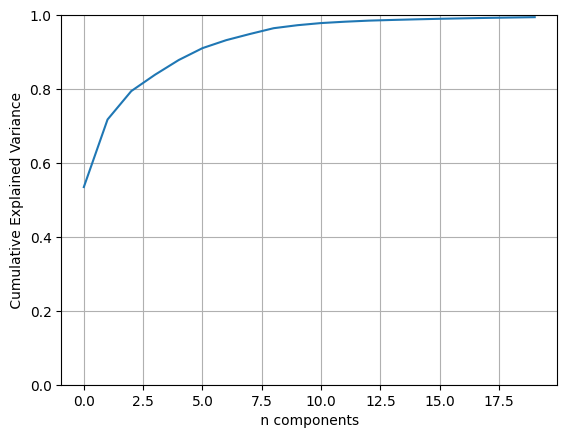

In [22]:
#get explained variance ratio to visually see how number of components affect variance
cum_var = np.cumsum(mypca.explained_variance_ratio_)

#print variance values for different number of componlents
print(cum_var)

#plot explained variance values
plt.plot(cum_var)
plt.ylim((0,1))
plt.xlabel(' n components ')
plt.ylabel(' Cumulative Explained Variance ')
plt.grid()

Since 9 components was ideal, PCA analysis was completed again using 9 components. THe explained variance ratio showed similar results.

[0.53479798 0.71760843 0.79449204 0.83871812 0.87855924 0.91067373
 0.93225627 0.94898232 0.96462536]


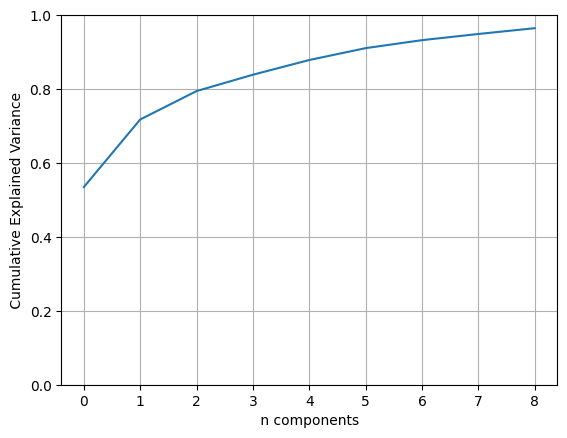

In [23]:
#Test myPCA class using reduction + SVM classifier with 9 components
mypca = myPCA(n_components=9)
mypca.fit(df_data)

#reduced dimensionality of data
df_data_reduced = mypca.transform(df_data)


#get explained variance ratio to visually see how number of components affect variance
cum_var = np.cumsum(mypca.explained_variance_ratio_)

#print variance values for different number of componlents
print(cum_var)

#plot explained variance values
plt.plot(cum_var)
plt.ylim((0,1))
plt.xlabel(' n components ')
plt.ylabel(' Cumulative Explained Variance ')
plt.grid()

The same analysis was done using skikit-learns built in PCA class. The results were very similar.

[0.53479798 0.71760843 0.79449204 0.83871812 0.87855924 0.91067373
 0.93225627 0.94898232 0.96462536]


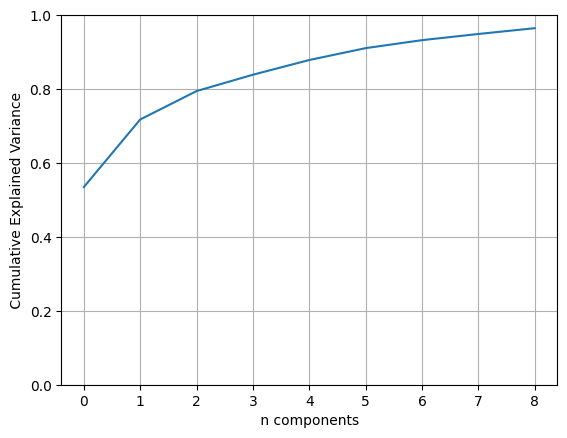

In [24]:
"""
1.2 PCA using scikit-learn:
a. Use the PCA module from sklearn to perform dimensionality reduction on the dataset.
"""

#Use PCA dimensionality reduction + SVM classifier

pca = PCA(n_components=9)
pca.fit(df_data)

#reduced dimensionality of data using sklearn
df_data_reduced = pca.transform(df_data)

#get explained variance ratio to visually see how number of components affect variance
pca_cum_var = np.cumsum(pca.explained_variance_ratio_)

#print variance values for different number of componlents
print(pca_cum_var)

#plot explained variance values
plt.plot(pca_cum_var)
plt.ylim((0,1))
plt.xlabel(' n components ')
plt.ylabel(' Cumulative Explained Variance ')
plt.grid()


The cumulative sum of explained variance ratios from the from scratch implementation was compared with sklearn implementation. The results were the same for both.

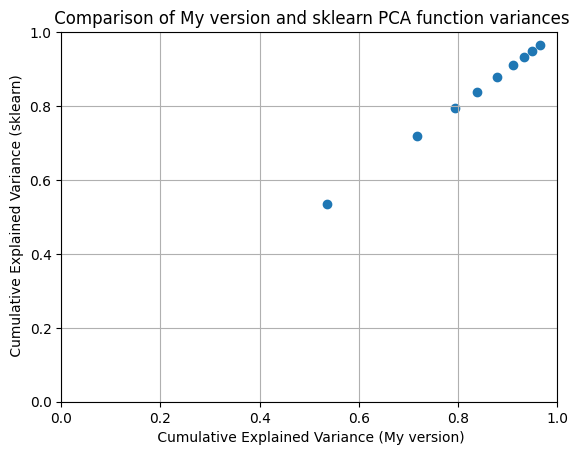

In [25]:
"""
b. Compare the results with your from-scratch implementation in terms of explained variance and the reduced feature set.
"""


#plot explained variance values computed using sklearn compared to from scratch implementation
xvals = np.arange(1, len(pca_cum_var)+1)
plt.scatter(cum_var, pca_cum_var)
plt.ylim((0,1))
plt.xlim((0,1))
plt.xlabel(' Cumulative Explained Variance (My version)')
plt.ylabel(' Cumulative Explained Variance (sklearn)')
plt.title(' Comparison of My version and sklearn PCA function variances')
plt.grid()

#The values are mostly identical

Kernel PCA class was then created. It included the same functions as in my implementation of PCA, plus helper functions to implement KPCA. It included parameters for kernel choice to implement linear, poly, or rbf.

In [26]:
"""
Part 2: Kernel PCA (KPCA)
2.1 KPCA with RBF Kernel:
a. Implement Kernel PCA with the Radial Basis Function (RBF) kernel from scratch.
"""

#Class for Kernel PCA

class myKPCA:
    def __init__(self, n_components, kernel, gamma=None, degree=3, coef0=1):
      self.n_components = n_components
      self.gamma = gamma
      self.kernel = kernel
      self.degree = degree
      self.coef0 = coef0
      self.X = None
      self.K = None
      self.K_centered = None
      self.alphas = None
      self.lambdas = None


    def _euclidiean_dist(self, X, Y):
      #Euclidiean Squared Distance Using formula D^2(X,Y) = X^2 + Y^2 - 2XY^T
      #compute squared euclidean distances
      X_norm = np.sum(X**2, axis=1)
      Y_norm = np.sum(Y**2, axis=1)

      #compute squared euclidiean distance overall
      #use X_norm as a column vector and Y_norm as a row vector
      sq_dist = X_norm[:, None] + Y_norm[None, :]-2*np.dot(X, Y.T)

      return sq_dist


    def _rbf_kernel(self, X, Y, gamma):
      #reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html
      #Euclidiean Distane
      sq_dist = self._euclidiean_dist(X, Y)

      #get kernel
      kern = np.exp(-gamma*sq_dist)
      return kern

    def _poly_kernel(self, X, Y):
      #calculate dot product for X and transposed Y and add coefficient
      #raise to degree
      kern = (np.dot(X, Y.T) + self.coef0) ** self.degree
      return kern

    def _linear_kernel(self, X, Y):
      #calculate dot product of X and transposed Y
      kern = np.dot(X, Y.T)
      return kern

    def _compute_kernel(self, X, Y=None):
      #If no value is used for Y, set it equal to X
      if Y is None:
        Y = X

      #choose correct kernel type
      if self.kernel == 'rbf':
        return self._rbf_kernel(X, Y, self.gamma)
      elif self.kernel == 'poly':
        return self._poly_kernel(X, Y)
      elif self.kernel == 'linear':
        return self._linear_kernel(X, Y)
      else:
        raise ValueError("Invalid kernel type. Chose 'linear', 'poly', or 'rbf'.")

    def _center_kernel_matrix(self, K, K_train=None):
      #reference https://github.com/scikit-learn/scikit-learn/blob/bccd697bb45c85e916c7d3004d1b5bc908d38a84/sklearn/preprocessing/_data.py#L2354
      #get number of samples - must use self.K if K_train is not given
      n_samples = self.K.shape[0] if K_train is None else K_train.shape[0]

      #average of each column of kernel matrix (features)
      K_fit_rows = np.sum(K, axis=0) / n_samples

      #average of each row of kernel matrix
      K_pred_cols = (np.sum(K, axis=1) / K_fit_rows.shape[0])[:, None]

      #average of kernel matrix
      K_fit_all = np.sum(K_fit_rows) / n_samples

      #center kernel matrix
      K = K - K_fit_rows - K_pred_cols + K_fit_all

      return K


    def fit(self, X):
      #compute kernel matrix
      self.X = X

      #choose gamma
      #If gamme = None, gamme = 1/n_features
      self.gamma = 1.0 / X.shape[1] if self.gamma is None else self.gamma

      #compute kernel
      self.K = self._compute_kernel(X)

      #center kernel matrix
      self.K_centered = self._center_kernel_matrix(self.K)

      #compute eigenvalues and eigenvectors
      eigenvalues, eigenvectors = np.linalg.eigh(self.K_centered)
      #reverse the order
      eigenvalues, eigenvectors = eigenvalues[::-1], eigenvectors[:, ::-1]

      #get alphas and lambdas
      self.alphas = eigenvectors[:, :self.n_components]
      self.lambdas = eigenvalues[:self.n_components]

    def transform(self, X):
      #compute kernel
      K_test = self._compute_kernel(X, self.X)

      #calculate centered data
      n = self.K.shape[0]

      #calculate centered data
      n = self.K.shape[0]
      m = K_test.shape[0]

      #get center matrix for K_test
      K_test_centered = self._center_kernel_matrix(K_test, self.K)

      #project data using principal components
      projected_data = np.dot(K_test_centered, self.alphas)

      return projected_data


#create kernelPCA object wit 4 components and rbf type
mykpca_r = myKPCA(n_components=9, kernel='rbf')
#fit data to kernelPCA
mykpca_r.fit(df_data)

#reduced dimensionality of data
df_data_reduced = mykpca_r.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)

(1091, 9)
[[-0.00074798  0.00087263 -0.0007631  ...  0.00101786 -0.00079783
   0.00073281]
 [-0.00093636  0.0010953  -0.00103149 ...  0.0014751  -0.00116432
   0.00109045]
 [-0.00063637  0.00074125 -0.000622   ...  0.00080132 -0.00062604
   0.00056987]
 ...
 [-0.00125157  0.00147056 -0.0015911  ...  0.00267818 -0.0021536
   0.00212992]
 [-0.00121998  0.0014328  -0.00152736 ...  0.00252007 -0.00202148
   0.00198441]
 [-0.00107523  0.00126022 -0.00125847 ...  0.00191662 -0.00152312
   0.00145446]]


In [27]:
#create kernelPCA object wit 4 components and rbf type
kpca = KernelPCA(n_components=9, kernel='rbf')
#fit data to kernelPCA
kpca.fit(df_data)

#reduced dimensionality of data
df_data_reduced = kpca.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)




(1091, 9)
[[ 4.55432276e-02  3.58321432e-01 -3.03033267e-02 ... -2.22705148e-02
   6.01782837e-04  8.31566039e-03]
 [-1.06212836e-03  2.56147106e-02 -6.29776779e-02 ...  1.99794585e-02
  -1.53088469e-02  2.58695320e-02]
 [-1.44392733e-02  3.72446099e-03  1.51800628e-03 ... -3.95872663e-04
  -2.32638504e-03 -5.12476296e-03]
 ...
 [-2.44651432e-03  3.42301740e-03  8.59892761e-04 ...  2.41134185e-04
  -2.32818220e-03 -2.74962464e-04]
 [-1.96017559e-03  3.03210797e-03  1.06542183e-03 ...  9.38583620e-04
  -1.61881132e-03 -1.23418299e-03]
 [-8.98821091e-04  3.00259816e-03  6.55727281e-04 ...  9.94339348e-04
  -1.59572796e-03 -1.15027777e-03]]


In [28]:
"""
2.2 KPCA with Polynomial Kernel:
a. Implement Kernel PCA with a Polynomial kernel from scratch. - see myPCA class above

b. Apply your KPCA implementation to the dataset.
"""

#create kernelPCA object wit 4 components and poly type
mykpca_p = myKPCA(n_components=9, kernel='poly')
mykpca_p.fit(df_data)

#reduced dimensionality of data
df_data_reduced = mykpca_p.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)

(1091, 9)
[[ 2.98532725e+35  7.16773387e+33 -6.30138177e+33 ... -4.34748304e+32
   1.02930383e+33 -1.82757245e+33]
 [ 1.28318293e+35 -9.16121512e+32 -3.58970718e+33 ...  1.38773429e+33
   6.79693871e+32 -4.64831365e+32]
 [ 1.51836177e+33 -4.40630506e+33 -1.30107639e+33 ...  3.71584146e+33
  -3.20146740e+32 -4.95088070e+31]
 ...
 [ 4.38679957e+34 -2.90716118e+33 -3.80727791e+33 ... -2.37941303e+32
   1.39140964e+32 -9.19911494e+32]
 [ 1.57268765e+34 -1.80172993e+33  5.12906675e+33 ... -1.20604043e+32
  -2.40369293e+32 -2.57560892e+31]
 [ 5.34059096e+32 -4.02143334e+33 -7.02778052e+32 ...  1.17313281e+33
   1.40530829e+32  1.73561773e+31]]


In [29]:

#sklearn KernelPCA for comparison
kpca_p = KernelPCA(n_components=9, kernel='poly')
kpca_p.fit(df_data)

#reduced dimensionality of data
df_data_reduced = kpca_p.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)

(1091, 9)
[[ 2.17441328e+12  1.39400335e+11  1.81976620e+11 ... -2.39099125e+10
  -6.95679235e+10  1.30236789e+11]
 [ 9.34627859e+11 -1.78170185e+10  1.03666591e+11 ...  7.63214099e+10
  -4.59387148e+10  3.31248969e+10]
 [ 1.10592447e+10 -8.56952022e+10  3.75735807e+10 ...  2.04360637e+11
   2.16378712e+10  3.52810427e+09]
 ...
 [ 3.19519922e+11 -5.65393824e+10  1.09949782e+11 ... -1.30860908e+10
  -9.40416331e+09  6.55548948e+10]
 [ 1.14549350e+11 -3.50406072e+10 -1.48121517e+11 ... -6.63287695e+09
   1.62459248e+10  1.83543389e+09]
 [ 3.88991074e+09 -7.82100961e+10  2.02954165e+10 ...  6.45189441e+10
  -9.49810809e+09 -1.23683794e+09]]


In [30]:
"""
2.3 KPCA with Linear Kernel:
a. Implement Kernel PCA with a Linear kernel from scratch.

b. Apply your KPCA implementation to the dataset.
"""

#create kernelPCA object wit 4 components and linear type
mykpca_l = myKPCA(n_components=9, kernel='linear')
mykpca_l.fit(df_data)

#reduced dimensionality of data
df_data_reduced = mykpca_l.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)


(1091, 9)
[[-1.24914104e+12  1.58648423e+11 -3.03282974e+10 ...  5.52710294e+09
  -1.37353630e+10  1.73273469e+10]
 [-7.89124620e+11  4.40222865e+10  1.88725360e+10 ... -6.93266481e+08
  -1.10705053e+10  1.27957872e+10]
 [-2.24190402e+11 -5.37226672e+10  5.68082805e+10 ... -1.00800469e+10
  -8.68751042e+09  1.34811662e+10]
 ...
 [-4.87537227e+11 -2.99077480e+10  7.14800146e+09 ...  3.11581248e+09
   1.34204181e+10  3.46466013e+09]
 [-2.15191820e+11  7.25466041e+10  4.78795115e+10 ...  1.48396826e+09
  -2.05121190e+10 -1.66777979e+10]
 [-2.08008481e+11 -3.76054314e+10  3.76232575e+10 ... -6.62156521e+09
  -3.72825619e+08  1.32607238e+10]]


In [31]:
#sklearn KernelPCA for comparison
kpca_l = KernelPCA(n_components=9, kernel='linear')
kpca_l.fit(df_data)

#reduced dimensionality of data
df_data_reduced = kpca_l.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)

(1091, 9)
[[-284154.50556346   61726.72079318   18195.71372261 ...   -6258.70219369
    17667.75515852   23046.73953344]
 [-179510.00643103   17128.13359299  -11322.73457201 ...     785.03123523
    14239.95694441   17019.40728947]
 [ -50998.81505997  -20902.34499933  -34082.59933467 ...   11414.30012677
    11174.71790808   17931.01551998]
 ...
 [-110904.93007722  -11636.46741857   -4288.50279814 ...   -3528.23940623
   -17262.64247749    4608.27155029]
 [ -48951.81834365   28226.33772749  -28725.71025365 ...   -1680.39487047
    26384.67557975  -22182.78815469]
 [ -47317.75298735  -14631.4719957   -22572.38554585 ...    7498.03380988
      479.56444617   17637.80972134]]


In [32]:
"""
2.4 Combining Kernels:
a. Combine two different kernels (e.g., RBF and Polynomial) and apply the combined KPCA to the dataset.

b. Evaluate the classification performance using accuracy metrics for the combined kernels.
"""

#combined KernelPCA that inherits functions/attributes from myKPCA class

class combinedKPCA(myKPCA):

    def __init__(self, n_components, kernel, kernel2, gamma=None, gamma2=None, degree=3, coef0=1):
      #inherit attributes of myKPCA using super function
      super().__init__(n_components, kernel, gamma, degree, coef0)
      #create attributes for kernel2 and gamma2
      self.kernel2 = kernel2
      self.gamma2 = gamma2

    def _compute_kernel_combined(self, X, Y=None):
      #comput combined kernel
      if Y is None:
        Y = X

      # Compute first kernel
      if self.kernel == 'rbf':
        K1 = self._rbf_kernel(X, Y, gamma=self.gamma)
      elif self.kernel == 'poly':
        K1 = self._poly_kernel(X, Y)
      elif self.kernel == 'linear':
        K1 = self._linear_kernel(X, Y)
      else:
        raise ValueError("Invalid kernel type. Choose 'linear', 'poly', or 'rbf'.")

      # Compute second kernel
      if self.kernel2 == 'rbf':
        K2 = self._rbf_kernel(X, Y, gamma=self.gamma2)
      elif self.kernel2 == 'poly':
        K2 = self._poly_kernel(X, Y)
      elif self.kernel2 == 'linear':
        K2 = self._linear_kernel(X, Y)
      else:
        raise ValueError("Invalid kernel2 type. Choose 'linear', 'poly', or 'rbf'.")

      # Combine kernels
      return K1 + K2

    def fit(self, X):
      self.X = X
      #set gamma value if it is None
      self.gamma = 1 / X.shape[1] if self.gamma is None else self.gamma
      self.gamma2 = 1 / X.shape[1] if self.gamma2 is None else self.gamma2

      #calculate combined kernel
      self.K = self._compute_kernel_combined(X)

      #center kernel matrix
      self.K_centered = self._center_kernel_matrix(self.K)

      #compute eigenvalues and eigenvectors
      eigenvalues, eigenvectors = np.linalg.eigh(self.K_centered)
      eigenvalues, eigenvectors = eigenvalues[::-1], eigenvectors[:, ::-1]

      #get alphas and lambdas
      self.alphas = eigenvectors[:, :self.n_components]
      self.lambdas = eigenvalues[:self.n_components]

    def transform(self, X):
      #compute kernel
      K_test = self._compute_kernel_combined(X, self.X)

      #center test kernel matrix
      K_test_centered = self._center_kernel_matrix(K_test, self.K)

      #project data using principal components
      projected_data = np.dot(K_test_centered, self.alphas)

      return projected_data


#create kernelPCA object wit 8 components and rbf type
ckpca = combinedKPCA(n_components=8, kernel='linear', kernel2='rbf')
ckpca.fit(df_data)
#fit data to kernelPCA
ckpca.fit(df_data)

#reduced dimensionality of data
df_data_reduced = ckpca.transform(df_data)

#print new data size and data
print(df_data_reduced.shape)
print(df_data_reduced)

#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)

#use svm to classify data
svm = SVC()
svm.fit(X_train, y_train)

#make predictions
y_pred_svm=svm.predict(X_test)

#get accuracy score
print(accuracy_score(y_test, y_pred_svm))



(1091, 8)
[[-1.24914104e+12  1.58648423e+11 -3.03282974e+10 ... -1.63185395e+10
   5.52710294e+09 -1.37353630e+10]
 [-7.89124620e+11  4.40222865e+10  1.88725360e+10 ...  9.59887080e+09
  -6.93266481e+08 -1.10705053e+10]
 [-2.24190402e+11 -5.37226672e+10  5.68082805e+10 ...  6.15511149e+09
  -1.00800469e+10 -8.68751042e+09]
 ...
 [-4.87537227e+11 -2.99077480e+10  7.14800146e+09 ... -2.69236497e+10
   3.11581248e+09  1.34204181e+10]
 [-2.15191820e+11  7.25466041e+10  4.78795115e+10 ...  3.90273533e+10
   1.48396826e+09 -2.05121190e+10]
 [-2.08008481e+11 -3.76054314e+10  3.76232575e+10 ...  9.19420473e+09
  -6.62156521e+09 -3.72825619e+08]]
0.54337899543379


[0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379, 0.54337899543379]


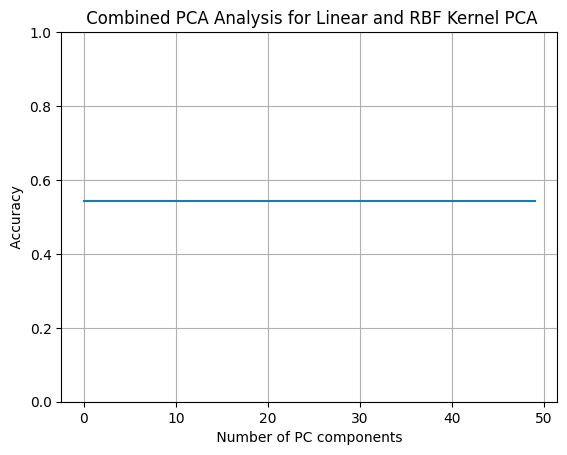

In [33]:
#create testing loop for different number of components using combined kernel PCA

accu = []
for i in range(1,51):
    ckpca = combinedKPCA(n_components=i, kernel='linear', kernel2='rbf')
    ckpca.fit(X_train)

    #reduced dimensionality of training data
    X_train_reduced = ckpca.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = ckpca.transform(X_test)

    #Use SVM as classifier on reduced dimensions

    #use SVM to classify cancer data
    svm = SVC()
    svm.fit(X_train_reduced, y_train) #train svm classifier

    #Make predictions
    y_pred_svm=svm.predict(X_test_reduced)

    #Get accuracy score
    accu.append(accuracy_score(y_test, y_pred_svm))

#display results
plt.plot(accu)
plt.ylim((0,1))
plt.xlabel(' Number of PC components ')
plt.ylabel(' Accuracy ')
plt.title(' Combined PCA Analysis for Linear and RBF Kernel PCA')
plt.grid()
print(accu)

Original X_train shape: (872, 1881)
Original X_test shape: (219, 1881)
Reduced X_train shape: (872, 50)
Reduced X_test shape: (219, 50)


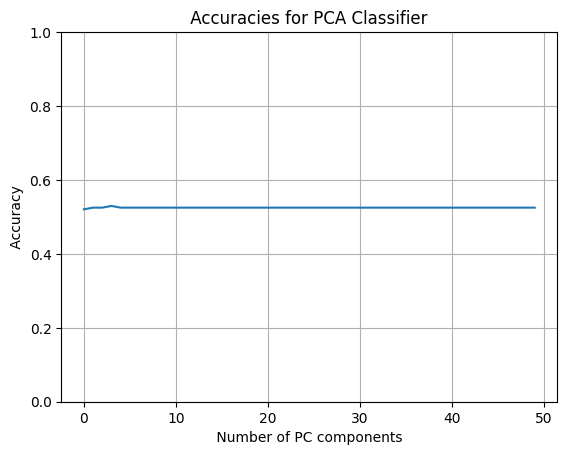

In [34]:
"""
3.1 Preparing the Data:
a. Split your Lung.csv into Train and Test datasets.
"""

#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)

"""
b. Use the PCA and KPCA models (RBF, Polynomial, Linear, and combined kernels) trained on the Train dataset to transform the Test dataset.
c. Ensure the dimensionality reduction is consistent with what was performed on the training data.
"""

#Use PCA model to train and test dataset
#create testing loop for different number of components
accu = []
for i in range(1,51):
    #create PCA classifier
    pca = PCA(n_components=i)
    pca.fit(X_train)

    #reduced dimensionality of training data
    X_train_reduced = pca.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = pca.transform(X_test)

    #Use SVM as classifier on reduced dimensions
    svm = SVC()
    svm.fit(X_train_reduced, y_train) #train svm classifier

    #Make predictions
    y_pred_svm=svm.predict(X_test_reduced)

    #Get accuracy score
    accu.append(accuracy_score(y_test, y_pred_svm))

#compare dimensions for last iteration
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Reduced X_train shape: {X_train_reduced.shape}")
print(f"Reduced X_test shape: {X_test_reduced.shape}")

plt.plot(accu)
plt.ylim((0,1))
plt.xlabel(' Number of PC components ')
plt.ylabel(' Accuracy ')
plt.title(' Accuracies for PCA Classifier ')
plt.grid()

Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 2

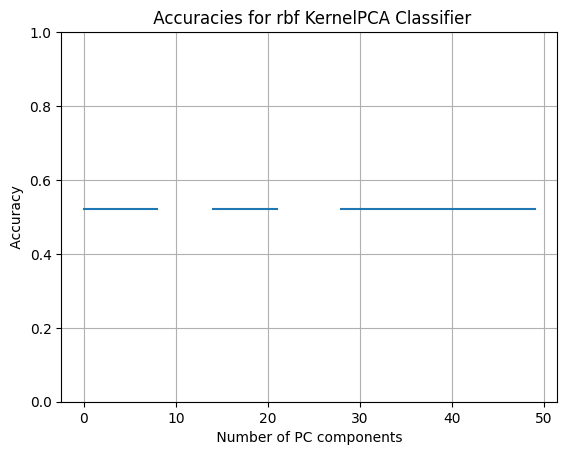

In [35]:
#Use rbf KernelPCA model to train and test dataset
#create testing loop for different number of components
accu = []
for i in range(1,51):
    #create rbf kernelPCA classifier
    kpca_r = KernelPCA(n_components=i, kernel='rbf')

    #handle exceptions for n_components that do not reduce with rbf
    try:
      kpca_r.fit(X_train)
    except Exception as e:
      accu.append(np.nan)
      print(f"Skipping iteration {i} due to {e}")
      continue

    #reduced dimensionality of training data
    X_train_reduced = kpca_r.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = kpca_r.transform(X_test)

    #Use SVM as classifier on reduced dimensions
    svm = SVC()
    svm.fit(X_train_reduced, y_train) #train svm classifier

    #Make predictions
    y_pred_svm=svm.predict(X_test_reduced)

    #Get accuracy score
    accu.append(accuracy_score(y_test, y_pred_svm))

#compare dimensions for last iteration
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Reduced X_train shape: {X_train_reduced.shape}")
print(f"Reduced X_test shape: {X_test_reduced.shape}")

plt.plot(accu)
plt.ylim((0,1))
plt.xlabel(' Number of PC components ')
plt.ylabel(' Accuracy ')
plt.title(' Accuracies for rbf KernelPCA Classifier')
plt.grid()

Original X_train shape: (872, 1881)
Original X_test shape: (219, 1881)
Reduced X_train shape: (872, 50)
Reduced X_test shape: (219, 50)


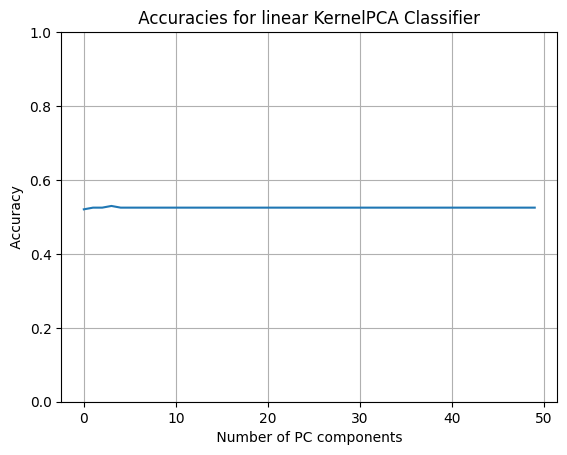

In [36]:
#Use linear KernelPCA model to train and test dataset
#create testing loop for different number of components
accu = []
for i in range(1,51):
    #create linear KernelPCA classifier
    kpca_l = KernelPCA(n_components=i, kernel='linear')
    kpca_l.fit(X_train)

    #reduced dimensionality of training data
    X_train_reduced = kpca_l.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = kpca_l.transform(X_test)

    #Use SVM as classifier on reduced dimensions
    svm = SVC()
    svm.fit(X_train_reduced, y_train) #train svm classifier

    #Make predictions
    y_pred_svm=svm.predict(X_test_reduced)

    #Get accuracy score
    accu.append(accuracy_score(y_test, y_pred_svm))

#compare dimensions for last iteration
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Reduced X_train shape: {X_train_reduced.shape}")
print(f"Reduced X_test shape: {X_test_reduced.shape}")

plt.plot(accu)
plt.ylim((0,1))
plt.xlabel(' Number of PC components ')
plt.ylabel(' Accuracy ')
plt.title(' Accuracies for linear KernelPCA Classifier ')
plt.grid()

Original X_train shape: (872, 1881)
Original X_test shape: (219, 1881)
Reduced X_train shape: (872, 50)
Reduced X_test shape: (219, 50)


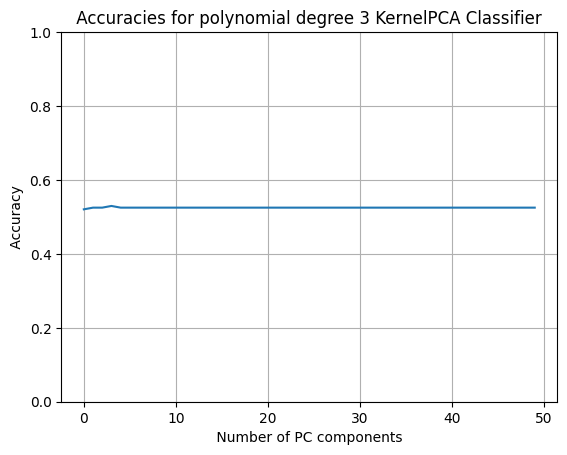

In [37]:
#Use polynomial KernelPCA model to train and test dataset
#create testing loop for different number of components
accu = []
for i in range(1,51):
    #create poly KernelPCA classifier, default degree of 3
    kpca_p = KernelPCA(n_components=i, kernel='poly')
    kpca_p.fit(X_train)

    #reduced dimensionality of training data
    X_train_reduced = kpca_p.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = kpca_p.transform(X_test)

    #Use SVM as classifier on reduced dimensions
    svm = SVC()
    svm.fit(X_train_reduced, y_train) #train svm classifier

    #Make predictions
    y_pred_svm=svm.predict(X_test_reduced)

    #Get accuracy score
    accu.append(accuracy_score(y_test, y_pred_svm))

#compare dimensions for last iteration
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Reduced X_train shape: {X_train_reduced.shape}")
print(f"Reduced X_test shape: {X_test_reduced.shape}")

plt.plot(accu)
plt.ylim((0,1))
plt.xlabel(' Number of PC components ')
plt.ylabel(' Accuracy ')
plt.title(' Accuracies for polynomial degree 3 KernelPCA Classifier ')
plt.grid()

Original X_train shape: (872, 1881)
Original X_test shape: (219, 1881)
Reduced X_train shape: (872, 50)
Reduced X_test shape: (219, 50)


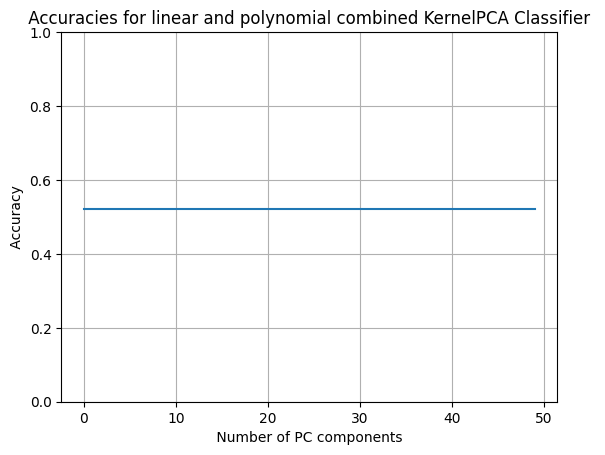

In [38]:
#Use linear and polynomial KernelPCA model to train and test dataset
#create testing loop for different number of components
accu = []
for i in range(1,51):
    #create combined linear and polynomial KernelPCA classifier
    kpca_lp = combinedKPCA(n_components=i, kernel='linear', kernel2='poly')

    #fit X_train using KernelPCA classifier
    kpca_lp.fit(X_train)

    #reduced dimensionality of training data
    X_train_reduced = kpca_lp.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = kpca_lp.transform(X_test)

    #Use SVM as classifier on reduced dimensions
    svm = SVC()
    svm.fit(X_train_reduced, y_train) #train svm classifier

    #Make predictions
    y_pred_svm=svm.predict(X_test_reduced)

    #Get accuracy score
    accu.append(accuracy_score(y_test, y_pred_svm))

#compare dimensions for last iteration
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Reduced X_train shape: {X_train_reduced.shape}")
print(f"Reduced X_test shape: {X_test_reduced.shape}")

plt.plot(accu)
plt.ylim((0,1))
plt.xlabel(' Number of PC components ')
plt.ylabel(' Accuracy ')
plt.title(' Accuracies for linear and polynomial combined KernelPCA Classifier ')
plt.grid()

In [39]:
"""
3.2 Covariance Matrix Analysis:
a. Calculate the covariance matrix of the dataset.
"""

df_cov = np.cov(df_data)
print(df_cov)
print(df_cov.shape)

[[2.01747276e+08 1.66459060e+08 1.24978858e+08 ... 1.41485961e+08
  1.31225324e+08 1.24483744e+08]
 [1.66459060e+08 1.39613391e+08 1.06653263e+08 ... 1.18301817e+08
  1.11138550e+08 1.05665199e+08]
 [1.24978858e+08 1.06653263e+08 8.54650513e+07 ... 9.04696660e+07
  8.63850378e+07 8.30722089e+07]
 ...
 [1.41485961e+08 1.18301817e+08 9.04696660e+07 ... 1.01664571e+08
  9.43748219e+07 9.00060807e+07]
 [1.31225324e+08 1.11138550e+08 8.63850378e+07 ... 9.43748219e+07
  9.47630456e+07 8.64394142e+07]
 [1.24483744e+08 1.05665199e+08 8.30722089e+07 ... 9.00060807e+07
  8.64394142e+07 8.22124882e+07]]
(1091, 1091)


In [40]:
"""
b. Identify the top 10 features with the highest covariance values.
"""

#get total covariance for each column
total_covs = np.sum(np.abs(df_cov), axis=1)

#sort the array
df_cov_sorted = np.argsort(total_covs)[::-1]

#debugging sorting
#print(df_cov_sorted)
#for i in range(1,11):
#  print(df_cov[0][df_cov_sorted[i]])

#print the top 10 values from df dataset along with their total covariance values
print("Top 10 features with highest covariance values")
for i in range(10):
  print(f"{i+1}: Feature {df.columns[df_cov_sorted[i]]} - Total Covariance: {total_covs[df_cov_sorted[i]]}")

Top 10 features with highest covariance values
1: Feature hsa-mir-1257 - Total Covariance: 138019509592.6394
2: Feature hsa-mir-4773-2 - Total Covariance: 136379957243.86087
3: Feature hsa-mir-4283-2 - Total Covariance: 136022544735.28075
4: Feature hsa-mir-4746 - Total Covariance: 134501085639.4164
5: Feature hsa-mir-4299 - Total Covariance: 130508978761.27538
6: Feature hsa-mir-4539 - Total Covariance: 127285351871.304
7: Feature hsa-mir-4477a - Total Covariance: 127056402982.94092
8: Feature hsa-mir-1181 - Total Covariance: 124573441201.45209
9: Feature hsa-mir-23c - Total Covariance: 123361422500.77382
10: Feature hsa-let-7a-1 - Total Covariance: 122561077092.77396


In [41]:
print(df_cov_sorted[:10])
top_df = df.iloc[:, df_cov_sorted[:10]]
top_df.head()

[  87 1057  707 1028  724  905  827   30  317    0]


,hsa-mir-1257,hsa-mir-4773-2,hsa-mir-4283-2,hsa-mir-4746,hsa-mir-4299,hsa-mir-4539,hsa-mir-4477a,hsa-mir-1181,hsa-mir-23c,hsa-let-7a-1
0,0.0,0.0,0,1.343295,0,0.0,0,0.000000,0.000000,7314.747386
1,0.0,0.0,0,3.839964,0,0.0,0,0.153599,0.000000,9518.042994
2,0.0,0.0,0,6.986318,0,0.0,0,0.000000,0.000000,4479.976340
3,0.0,0.0,0,1.683206,0,0.0,0,0.280534,0.280534,21277.962603
4,0.0,0.0,0,2.990331,0,0.0,0,0.460051,0.000000,8002.355461


In [42]:
"""
3.3 Classification Experiment:
a. Implement the following classifiers:
  - Minimum Distance Classifier (build from scratch)
"""

#Class for minimum distance classifier

class myMDC:
    def __init__(self):
      #initialize class means
      self.class_means = None
      #initialize unique class labels
      self.classes = None

    def _dis1(self, x, y):
      #local linear distance function using norm2
      dist = np.linalg.norm(x-y, ord=2)
      return dist

    def predict(self, X):
      #create distance array of zeros
      n_samples = X.shape[0]
      n_classes = len(self.class_means)
      distances = np.zeros((n_samples, n_classes))

      for idx, x in enumerate(X):
        #iterate over test samples X
        for cls_idx, cls_mean in enumerate(self.class_means):
          #iterate over class centroids and calculate distances
          distances[idx, cls_idx] = self._dis1(x, cls_mean)

      #assign class with minimum distance for each sample
      prediction = self.classes[np.argmin(distances, axis=1)]
      return prediction

    def fit(self, X, y):
      """
      Train the Minimum Distance classifier.

      Parameters:
      X: np.ndarray
            Feature matrix of shape (n_samples, n_features)
      y: np.ndarray
          Class labels of shape (n_samples,)
      """

      #set classes as labels, unique values in y
      self.classes = np.unique(y)
      #get number of classes
      n_classes = len(self.classes)
      #get number of features
      n_features = X.shape[1]

      #get class means as array using number of classes and features
      self.class_means = np.zeros((n_classes, n_features))

      #get mean for each class
      for idx, cls in enumerate(self.classes):
        #extract anything that belongs to the class to X_cls
        X_cls = X[y == cls]

        #compute the mean vector
        self.class_means[idx, :] = np.mean(X_cls, axis=0)


#test minimum distance classifier
MDC = myMDC()

#fit data
MDC.fit(X_train, y_train)

#get predictions
y_pred=MDC.predict(X_test)

#get accuracy score
print(accuracy_score(y_test,y_pred))

0.2420091324200913


In [43]:
"""
- Bayes Classifier (build from scratch)
"""

#Bayes Classifier Class

class BayesClassifier:
    def __init__(self):
        self.classes = None
        self.priors = None
        self.mean = None
        self.variance = None

    def fit(self, X, y):
        """
        Train the Bayes classifier.

        Parameters:
        X: np.ndarray
            Feature matrix of shape (n_samples, n_features)
        y: np.ndarray
            Class labels of shape (n_samples,)
        """

        self.classes = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes)

        #Initialize arrays to store class-wise statistics
        self.mean = np.zeros((n_classes, n_features))
        self.variance = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.variance[idx, :] = X_c.var(axis=0)
            self.priors[idx] = X_c.shape[0] / float(X.shape[0])

    def _calculate_likelihood(self, mean, var, x):
        """
        Calculate the Gaussian likelihood of the data.
        """
        #Add small epsilon to variance to avoid division by 0
        eps = 1e-6
        coeff = 1 / np.sqrt(2 * np.pi * (var + eps))
        exponent = -((x - mean) ** 2) / (2 * (var + eps))
        return coeff * np.exp(exponent)

    def _calculate_posterior(self, X):
        """
        Calculate posterior probability for each class
        """

        posteriors = []
        for idx, cls in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            likelihood = np.sum(np.log(self._calculate_likelihood(self.mean[idx, :], self.variance[idx, :], X)), axis=1)
            posteriors.append(prior + likelihood)
        return np.array(posteriors).T

    def predict(self, X):
        """
        Predict class labels for input data.
        """
        posteriors = self._calculate_posterior(X)
        return self.classes[np.argmax(posteriors, axis=1)]

#test Bayes classifier
B = BayesClassifier()

#fit data
B.fit(X_train, y_train)

#make predictions
y_pred=B.predict(X_test)

#get accuracy score
print(accuracy_score(y_test,y_pred))


0.2146118721461187


<ipython-input-43-5aaecad905f6>:58: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self._calculate_likelihood(self.mean[idx, :], self.variance[idx, :], X)), axis=1)


In [44]:
"""
  - Naive Bayes Classifier (using sklearn)
"""

#Use Naive Bayes Classifier
NB = GaussianNB()

#train classifier
NB.fit(X_train, y_train)

#Make predictions
y_pred=NB.predict(X_test)

#get accuracy score
print(accuracy_score(y_test,y_pred))


0.0958904109589041


In [45]:
"""
  - KNN Classifier (using sklearn)
"""

#use KNN as dimensionality reduction + nearest neighbor classifier

KNN = KNeighborsClassifier(n_neighbors=5)

#train classifier
KNN.fit(X_train, y_train)

#Make predictions
y_pred=KNN.predict(X_test)

#get accuracy score
print(accuracy_score(y_test,y_pred))


0.4429223744292237


In [46]:
"""
  - LDA Classifier (using sklearn)
"""

#use KNN as dimensionality reduction + nearest neighbor classifier

LDA = LinearDiscriminantAnalysis()

#train classifier
LDA.fit(X_train, y_train)

#Make predictions
y_pred=LDA.predict(X_test)

#get accuracy score
print(accuracy_score(y_test,y_pred))

0.3059360730593607


In [49]:
#create function for KDF to be used in other functions
def KDF(kernel_type):
  # Iterate through kernels
  # Calculate kernel matrix using sklearn pairwise_kernels function
  if kernel_type == 'poly':
    #if kernel type is poly, set metrics for polynomial and degree
    k_train = pairwise_kernels(X_train, X_train, metric='polynomial', degree=3)
    k_test = pairwise_kernels(X_test, X_train, metric='polynomial', degree=3)
  else:
    #use defaults for rbf and linear
    k_train = pairwise_kernels(X_train, X_train, metric=kernel_type)
    k_test = pairwise_kernels(X_test, X_train, metric=kernel_type)

  # Center the kernel matrix using sklearn KernelCenterer
  kcenter = KernelCenterer()
  kcenter_train = kcenter.fit_transform(k_train)
  kcenter_test = kcenter.transform(k_test)

  # Apply KDA
  #use solver='lsqr' and shrinkage='auto' to prevent SVD failure
  return LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'), kcenter_train, kcenter_test

In [50]:
"""
  - Kernel Discriminant Analysis (KDA) with RBF, Polynomial, and Linear kernels
"""

#use kernels linear, poly, and rbf
kernels = ['linear', 'poly', 'rbf']

# Iterate through kernels
for kernel_type in kernels:
    kda, kcenter_train, kcenter_test = KDF(kernel_type)
    kda.fit(kcenter_train, y_train)
    y_pred = kda.predict(kcenter_test)

    #get accuracy score
    print(f"KDA with {kernel_type} kernel type: {accuracy_score(y_test,y_pred)}")


KDA with linear kernel type: 0.5251141552511416
KDA with poly kernel type: 0.5205479452054794
KDA with rbf kernel type: 0.5205479452054794


0.2420091324200913
Best number of components: 1
Highest accuracy: 0.2785388127853881
The number of components with highest accuracy is 1 with accuracy score 0.2785388127853881.


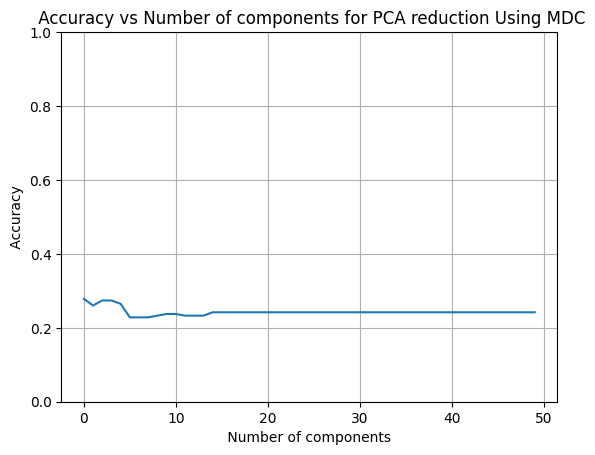

In [132]:
"""
b. Test the classifiers on: - Whole data
- Data reduced by PCA
- Data reduced by KPCA with RBF, Polynomial, and Linear kernels -
- Data reduced by the top 10 features(PCA and KPCA here by using SKLEARN)
c. For each classifier and dimensionality reduction technique,
find the best number of components that yield the highest classification accuracy.

d. Plot accuracy versus the number of components for
each classifier and dimensionality reduction technique.

e. Evaluate the classification performance
using accuracy metrics (accuracy, precision, recall)
and compare the effectiveness of PCA features, KPCA features,
and top 10 features.
"""

#to minimize code repetition, functions were created for plotting and getting accuracies for each set
def choose_reducer(reduction_method, n):
  #choose correct reduction method
  if reduction_method == 'PCA':
    reducer = PCA(n_components=n)
  elif reduction_method == 'KPCA_linear':
    reducer = KernelPCA(n_components=n, kernel='linear')
  elif reduction_method == 'KPCA_poly':
    reducer = KernelPCA(n_components=n, kernel='poly')
  elif reduction_method == 'KPCA_rbf':
    reducer = KernelPCA(n_components=n, kernel='rbf')
  elif reduction_method == 'Top10':
    reducer = SelectKBest(score_func=f_classif, k=10)
  elif reduction_method == 'TopK':
    reducer = SelectKBest(score_func=f_classif, k=n)
  else:
    raise ValueError("Invalid reduction method")

  return reducer

def choose_classifier(classifier):
  #Use classifier method
  if classifier == 'SVM':
    return SVC()
  elif classifier == 'MDC':
    return myMDC()
  elif classifier == 'Bayes':
    return BayesClassifier()
  elif classifier == 'Naive Bayes':
    return GaussianNB()
  elif classifier == 'KNN':
    return KNeighborsClassifier(n_neighbors=5)
  elif classifier == 'LDA':
    return LinearDiscriminantAnalysis()
  elif classifier == 'KDAR':
    return KDF('rbf')
  elif classifier == 'KDAP':
    return KDF('poly')
  elif classifier == 'KDAL':
    return KDF('linear')
  else:
    raise ValueError("Invalid classifier method")

def test_and_plot(reduction_method, classifier, X_train, X_test, y_train, y_test, start_components=20, max_components=50):
  #Now testing with data reduced by chosen method with chosen classifier

  #get model with correct reduction method
  reducer = choose_reducer(reduction_method, start_components)

  #fit data to reducer
  if reduction_method == 'TopK' or reduction_method == 'Top10':
    reducer.fit(X_train, y_train)
  else:
    reducer.fit(X_train)

  #reduced dimensionality of training data
  X_train_reduced = reducer.transform(X_train)

  #reduced dimensionality of testing data
  X_test_reduced = reducer.transform(X_test)

  #Use classifier chosen on reduced dimensions
  #special conditions for KDA classifiers
  if classifier in ['KDAR', 'KDAP','KDAL']:
    cls, kcenter_train, kcenter_test = choose_classifier(classifier)
    #use kcenter to train
    cls.fit(kcenter_train, y_train)
    #make predictions
    y_pred_cls = cls.predict(kcenter_test)

  else:
    cls = choose_classifier(classifier)
    cls.fit(X_train_reduced, y_train) #train classifier
    #Make predictions
    y_pred_cls=cls.predict(X_test_reduced)

  #Get accuracy score
  print(accuracy_score(y_test, y_pred_cls))

  #create testing loop for different number of components
  #empty list for accuracy scores
  accu = []
  highest_acc = 0
  best_n = 0

  for i in range(1, max_components+1):
    #loop for 1 to 50 components
    reducer = choose_reducer(reduction_method, i)

    if reduction_method in ['TopK', 'Top10']:
      reducer.fit(X_train, y_train)
    else:
      try:
        reducer.fit(X_train)
      except Exception as e:
        accu.append(np.nan)
        print(f"Skipping iteration {i} due to {e}")
        continue

    #reduced dimensionality of training data
    X_train_reduced = reducer.transform(X_train)

    #reduced dimensionality of testing data
    X_test_reduced = reducer.transform(X_test)

    #use chosen classifer to classify cancer data

    if classifier in ['KDAR', 'KDAP','KDAL']:
      cls, kcenter_train, kcenter_test = choose_classifier(classifier)
      #use kcenter to train
      cls.fit(kcenter_train, y_train)
      #make predictions
      y_pred_cls = cls.predict(kcenter_test)

    else:
      cls = choose_classifier(classifier)
      cls.fit(X_train_reduced, y_train) #train classifier
      #Make predictions
      y_pred_cls=cls.predict(X_test_reduced)


    #Get accuracy score
    acc_score = accuracy_score(y_test, y_pred_cls)
    accu.append(acc_score)
    if acc_score > highest_acc:
      highest_acc = acc_score
      best_n = i

  print(f"Best number of components: {best_n}")
  print(f"Highest accuracy: {highest_acc}")

  #Plot accuracy vs number components
  plt.plot(accu)
  plt.ylim((0,1))
  plt.xlabel(' Number of components ')
  plt.ylabel(' Accuracy ')
  plt.title(f' Accuracy vs Number of components for {reduction_method} reduction Using {classifier}')
  plt.grid()

  print(f"The number of components with highest accuracy is {best_n} with accuracy score {highest_acc}.")
  return best_n, highest_acc

#tested with whole data above for each classifier
#Now testing with data reduced by PCA with MDC classifier
#test with data reduced by PCA
best_n, highest_acc = test_and_plot('PCA', 'MDC', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [85]:
#Evaluate classification performance for PCA with MDC using ideal number of components
def eval_model(reduction_method, classifier, best_n, X_train, X_test, y_train, y_test):
  #function to simplify evaluating models so I don't have to keep repeating code

  reducer = choose_reducer(reduction_method, best_n)

  if reduction_method in ['TopK', 'Top10']:
    reducer.fit(X_train, y_train)
  else:
    reducer.fit(X_train)

  X_train_reduced = reducer.transform(X_train)
  X_test_reduced = reducer.transform(X_test)

  if classifier in ['KDAR','KDAP','KDAL']:
    cls, kcenter_train, kcenter_test = choose_classifier(classifier)
    #use kcenter to train
    cls.fit(kcenter_train, y_train)
    #make predictions
    y_pred_cls = cls.predict(kcenter_test)

  else:
    cls = choose_classifier(classifier)
    cls.fit(X_train_reduced, y_train) #train classifier
    #Make predictions
    y_pred_cls=cls.predict(X_test_reduced)

  #get metrics
  acc_score = accuracy_score(y_test, y_pred_cls)
  prec_score = precision_score(y_test, y_pred_cls, average='weighted')
  rec_score = recall_score(y_test, y_pred_cls, average='weighted')

  print(f"Accuracy: {acc_score}")
  print(f"Precision: {prec_score}")
  print(f"Recall: {rec_score}")

  return acc_score, prec_score, rec_score

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'MDC', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.2785388127853881
Precision: 0.28409195273642546
Recall: 0.2785388127853881


0.5205479452054794
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
S

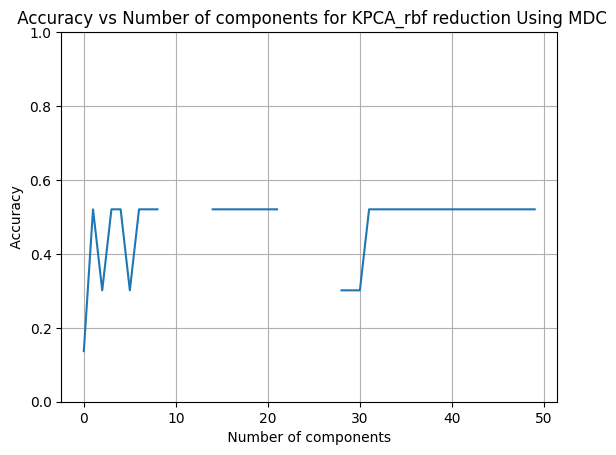

In [63]:
#test rbf KPCA for 20 components with MDC classifier
best_n, highest_acc = test_and_plot('KPCA_rbf', 'MDC', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [86]:
#Evaluate classification performance for rbf KPCA with MDC using ideal number of components

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'MDC', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.3013698630136986
Precision: 0.09082379433289547
Recall: 0.3013698630136986


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.2420091324200913
Best number of components: 1
Highest accuracy: 0.2785388127853881
The number of components with highest accuracy is 1 with accuracy score 0.2785388127853881.


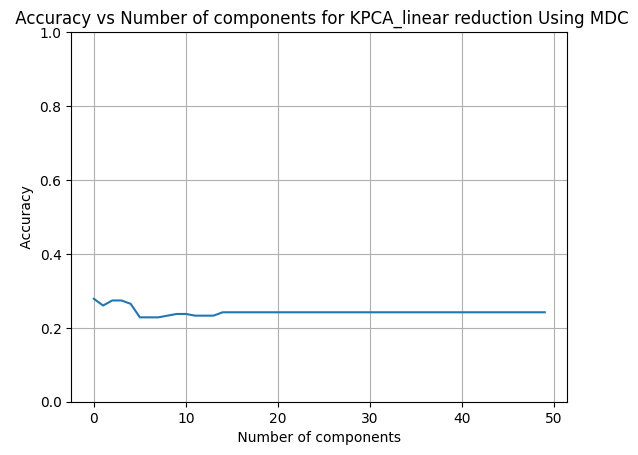

In [66]:
#test linear KPCA for 20 components with MDC classifier
best_n, highest_acc = test_and_plot('KPCA_linear', 'MDC', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [87]:
#Evaluate classification performance for linear KPCA with MDC using ideal number of components

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'MDC', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KernelPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.2785388127853881
Precision: 0.28409195273642546
Recall: 0.2785388127853881


0.0821917808219178
Best number of components: 5
Highest accuracy: 0.0958904109589041
The number of components with highest accuracy is 5 with accuracy score 0.0958904109589041.


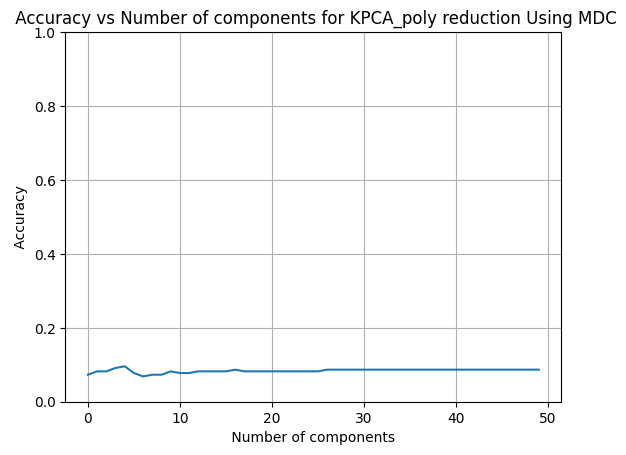

In [68]:
#test polynomial KPCA for 20 components with MDC classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'MDC', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [88]:
#Evaluate classification performance for polynomial KPCA with MDC using ideal number of components

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'MDC', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KernelPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.0730593607305936
Precision: 0.43085347147911046
Recall: 0.0730593607305936


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.1232876712328767


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.1232876712328767
The number of components with highest accuracy is 1 with accuracy score 0.1232876712328767.


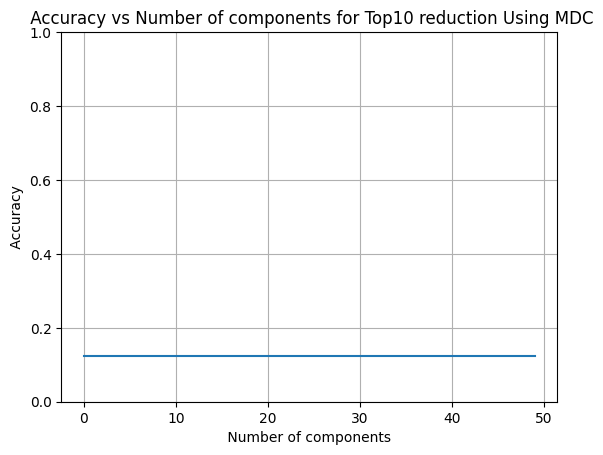

In [70]:
#test top 10 features with MDC classifier

best_n, highest_acc = test_and_plot('Top10', 'MDC', X_train, X_test, y_train, y_test, start_components=20, max_components=50)


In [89]:
#Evaluate classification performance for top10 with MDC using ideal number of components

acc_score, prec_score, rec_score = eval_model('Top10', 'MDC', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': 10, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}


Accuracy: 0.1232876712328767
Precision: 0.376604658742367
Recall: 0.1232876712328767


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

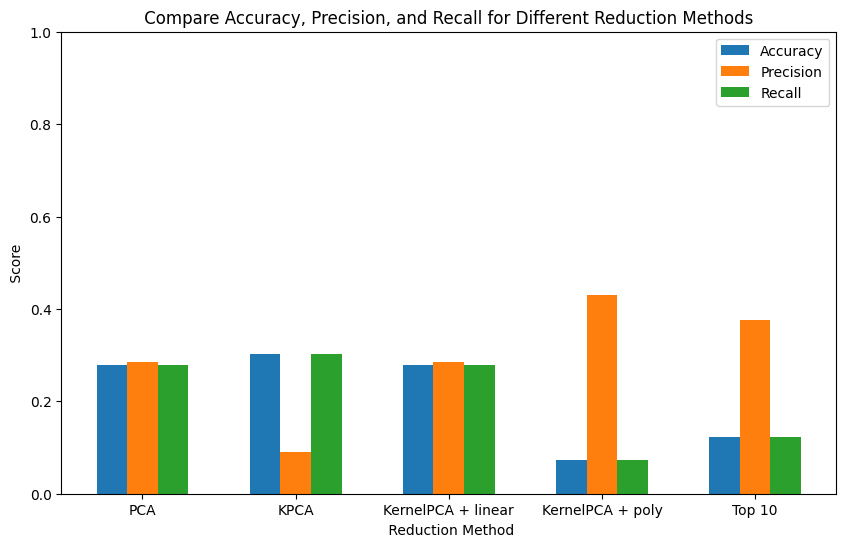

In [90]:
#compare the accuracy, precision, and recall for each reduction method using MDC

#Create a function to compare methods
def compare_methods(comparison_dict):
  #function to compare the
  #extract the methods used
  methods = list(comparison_dict.keys())

  #extract the accuracies, precisions, and recalls for each method
  accuracies = [comparison_dict[method]['Accuracy'] for method in methods]
  precisions = [comparison_dict[method]['Precision'] for method in methods]
  recalls = [comparison_dict[method]['Recall'] for method in methods]

  #create a bar chart to compare

  #get locations for bars
  xlocs = np.arange(len(methods))
  #set width for each bar
  bar_width = 0.2

  #create bar chart
  plt.figure(figsize=(10,6))

  plt.bar(xlocs-bar_width, accuracies, width=bar_width, label='Accuracy')
  plt.bar(xlocs, precisions, width=bar_width, label='Precision')
  plt.bar(xlocs+bar_width, recalls, width=bar_width, label='Recall')

  #set xticks
  plt.xticks(xlocs, methods)
  plt.legend()
  plt.ylim(0, 1)
  plt.title(' Compare Accuracy, Precision, and Recall for Different Reduction Methods ')
  plt.xlabel(' Reduction Method')
  plt.ylabel(' Score ')
  #plt.grid()

  plt.show()

compare_methods(comparison_dict)

Comparison shows that when using MDC classifier, KernelPCA + RBF is the best reduction technique for Accuracy and Recall, however the other methods have better precision. PCA and KernelPCA + linear have the highest precision and similar accuracy and recall.

0.3105022831050228
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


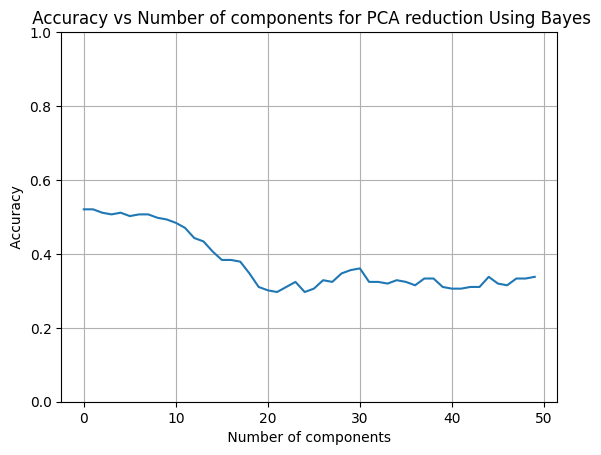

In [74]:
#Testing Bayes
#test PCA for 20 components with Bayes classifier

best_n, highest_acc = test_and_plot('PCA', 'Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [91]:
#Evaluate classification performance for PCA with Bayes using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0136986301369863
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
S

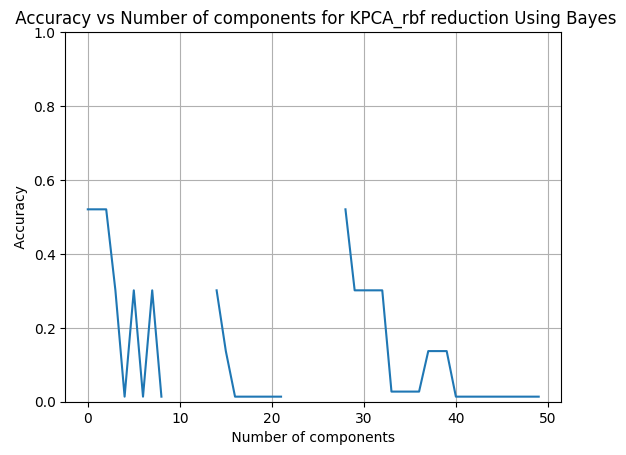

In [76]:
#Testing Bayes
#test rbf KernelPCA for 20 components with Bayes classifier
best_n, highest_acc = test_and_plot('KPCA_rbf', 'Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [92]:
#test rbf KPCA for ideal number of components with Bayes classifier

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.3105022831050228
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


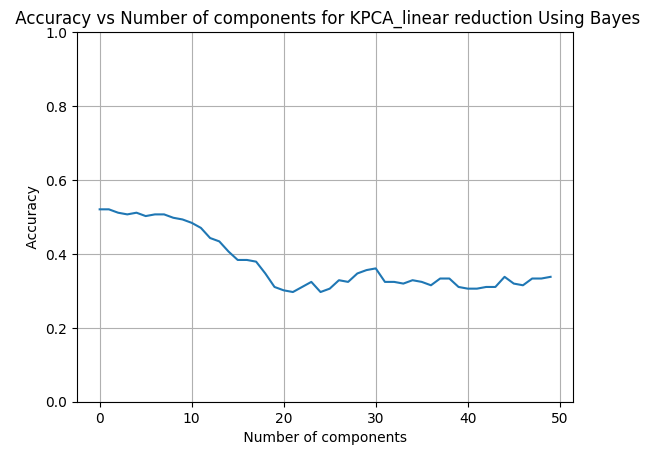

In [78]:
#Testing Bayes
#test linear KernelPCA for 20 components with Bayes classifier
best_n, highest_acc = test_and_plot('KPCA_linear', 'Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)


In [93]:
#test linear KPCA for ideal number of components with Bayes classifier

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.4246575342465753
Best number of components: 3
Highest accuracy: 0.5296803652968036
The number of components with highest accuracy is 3 with accuracy score 0.5296803652968036.


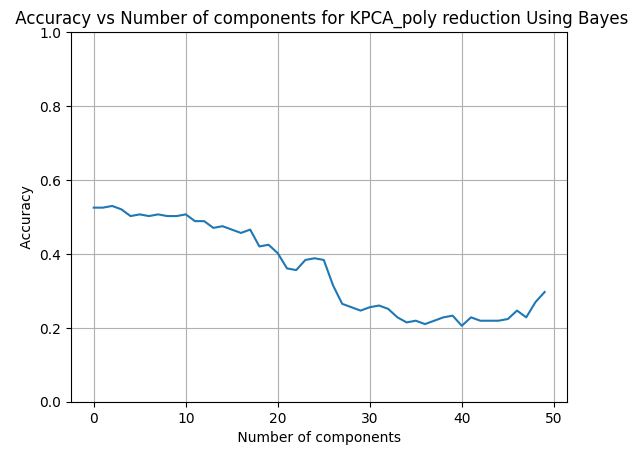

In [80]:
#Testing Bayes
#test polynomial KernelPCA for 20 components with Bayes classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [94]:
#test polynomial KPCA for ideal number of components with Bayes classifier

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.2871662142541506
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.2831050228310502


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.2831050228310502
The number of components with highest accuracy is 1 with accuracy score 0.2831050228310502.


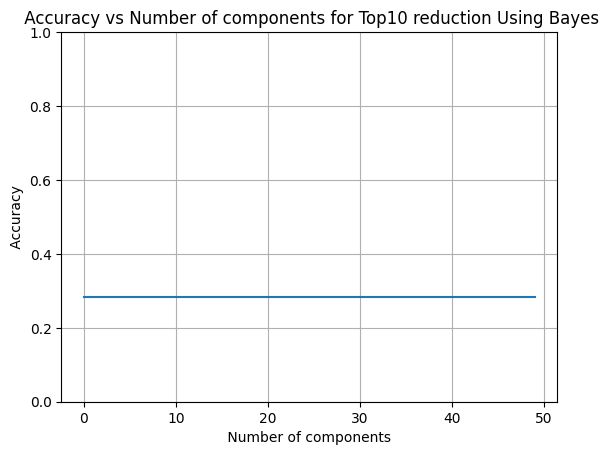

In [82]:
#test top 10 features with Bayes classifier

best_n, highest_acc = test_and_plot('Top10', 'Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [95]:
#Evaluate classification performance for top10 with Bayes classifier

acc_score, prec_score, rec_score = eval_model('Top10', 'Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': 10, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.2831050228310502
Precision: 0.09398407449895405
Recall: 0.2831050228310502


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

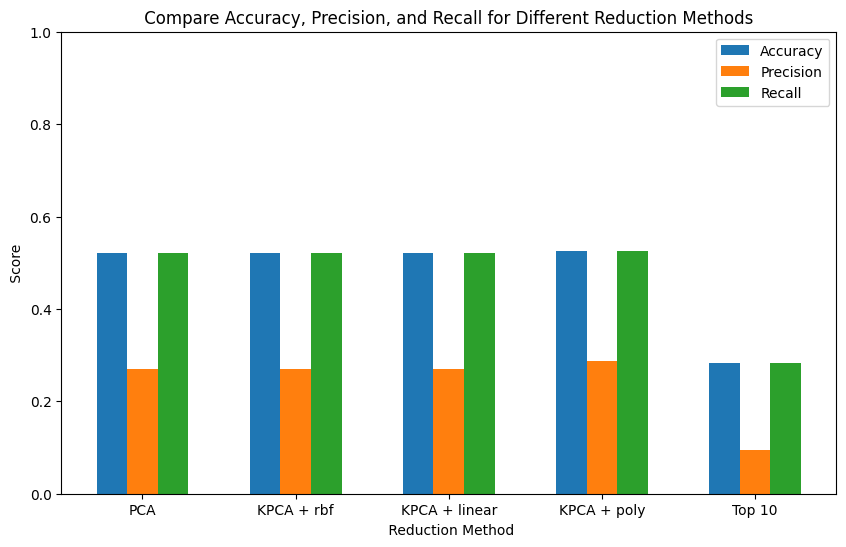

In [96]:
#compare the accuracy, precision, and recall for each reduction method using Bayes Classifier

compare_methods(comparison_dict)

When using Bayes Classifier, RBF had the best precision, but low accuracy/recall. PCA or KPCA + linear seem to have best accuracy, precision, and recall overall. Top 10 reduction method has lowest.

0.3105022831050228
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


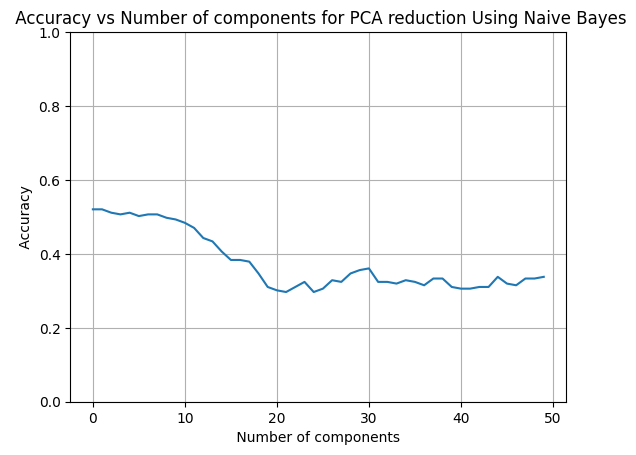

In [97]:


#test with PCA and naive bayes classifier

best_n, highest_acc = test_and_plot('PCA', 'Naive Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)


In [99]:
#Evaluate classification performance for PCA with Naive Bayes using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'Naive Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0136986301369863
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
S

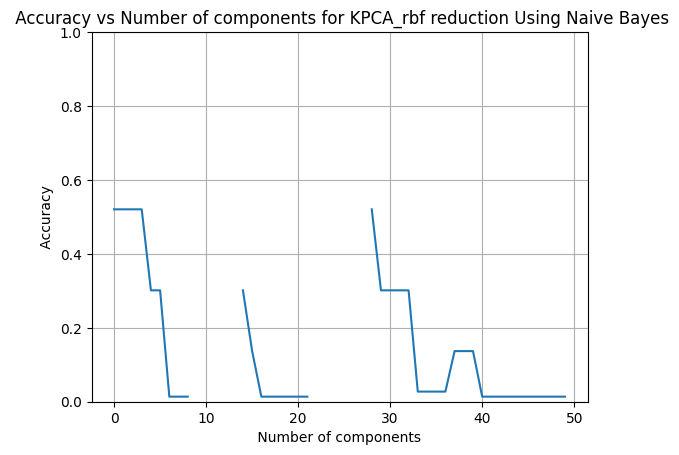

In [100]:
#Tests rbf KPCA for 20 components with Naive Bayes classifier

best_n, highest_acc = test_and_plot('KPCA_rbf', 'Naive Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [101]:
#evaluate classifications for rbf KPCA with Naive Bayes classifier

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'Naive Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.3013698630136986
Precision: 0.09082379433289547
Recall: 0.3013698630136986


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.3105022831050228
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


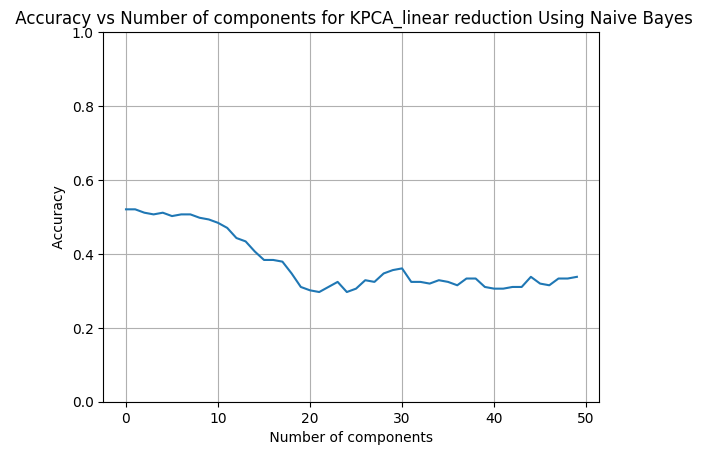

In [102]:
#Tests linear KPCA for 20 components with Naive Bayes classifier

best_n, highest_acc = test_and_plot('KPCA_linear', 'Naive Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [103]:
#evaluate classifications for linear KPCA with Naive Bayes classifier

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'Naive Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.4246575342465753
Best number of components: 3
Highest accuracy: 0.5296803652968036
The number of components with highest accuracy is 3 with accuracy score 0.5296803652968036.


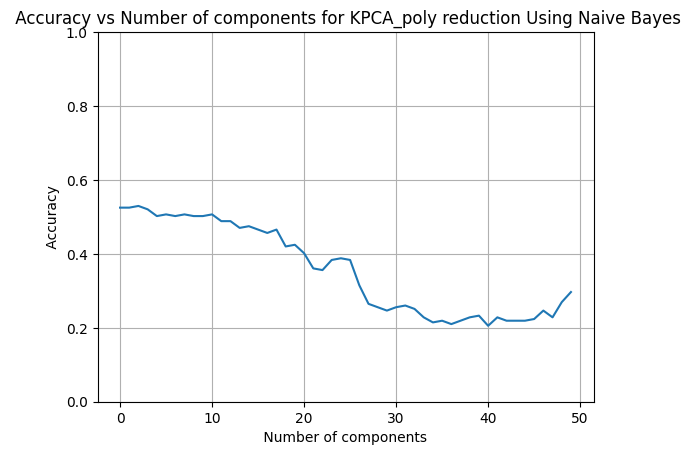

In [104]:
#Tests polynomial KPCA for 20 components with Naive Bayes classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'Naive Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [105]:
#evaluate classifications for polynomial KPCA with Naive Bayes classifier

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'Naive Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5296803652968036
Precision: 0.4769247106297122
Recall: 0.5296803652968036


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.2876712328767123


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.2876712328767123
The number of components with highest accuracy is 1 with accuracy score 0.2876712328767123.


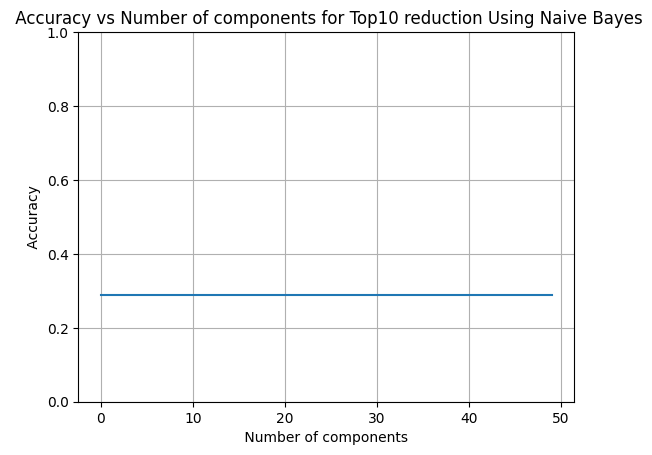

In [106]:
#Tests top10 for 20 components with Naive Bayes classifier

best_n, highest_acc = test_and_plot('Top10', 'Naive Bayes', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [107]:
#evaluate classifications for Top 10 with Naive Bayes classifier

acc_score, prec_score, rec_score = eval_model('Top10', 'Naive Bayes', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.2876712328767123
Precision: 0.09412820853836946
Recall: 0.2876712328767123


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

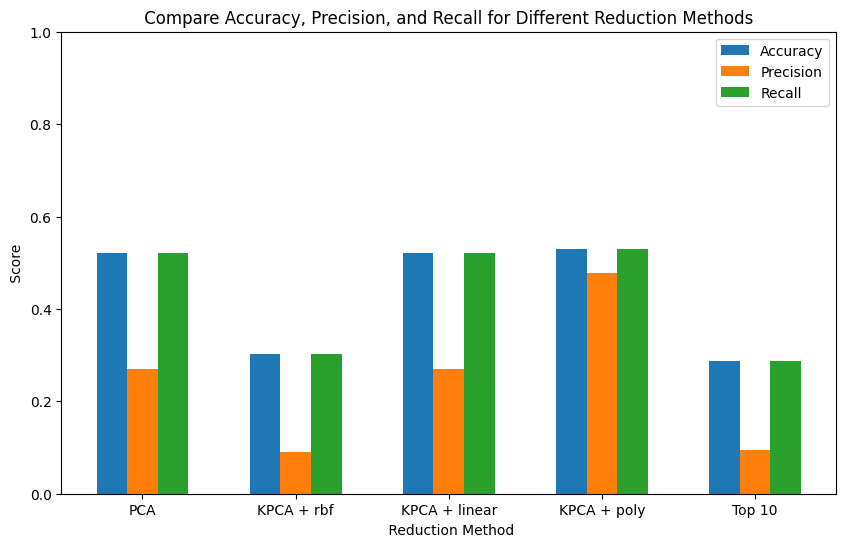

In [108]:
#compare the accuracy, precision, and recall for each reduction method using NB Classifier

compare_methods(comparison_dict)

KCPA + poly seems to have the best overall results with the highest precision. The Accuracy and recall is also high, but it is about the same as PCA and KPCA + linear

0.4611872146118721
Best number of components: 3
Highest accuracy: 0.4748858447488584
The number of components with highest accuracy is 3 with accuracy score 0.4748858447488584.


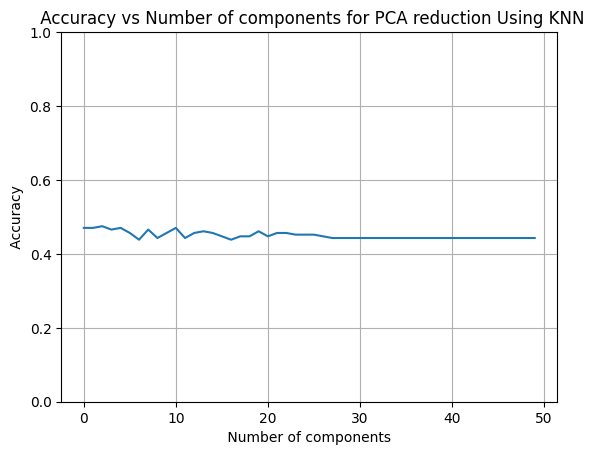

In [109]:
#Tests PCA or 20 components with KNN classifier

best_n, highest_acc = test_and_plot('PCA', 'KNN', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [110]:
#Evaluate classification performance for PCA with Naive Bayes using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'KNN', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.4748858447488584
Precision: 0.38736681887366814
Recall: 0.4748858447488584


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.3013698630136986
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
S

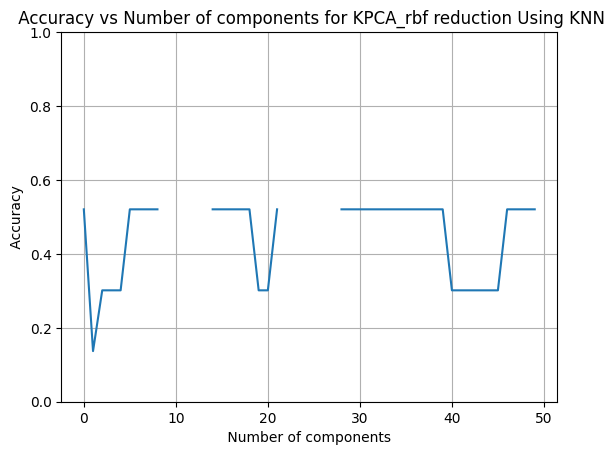

In [111]:
#Tests rbf KPCA or 20 components with KNN classifier

best_n, highest_acc = test_and_plot('KPCA_rbf', 'KNN', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [112]:
#evaluate rbf KPCA with KNN clasififer
acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'KNN', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.4611872146118721
Best number of components: 3
Highest accuracy: 0.4748858447488584
The number of components with highest accuracy is 3 with accuracy score 0.4748858447488584.


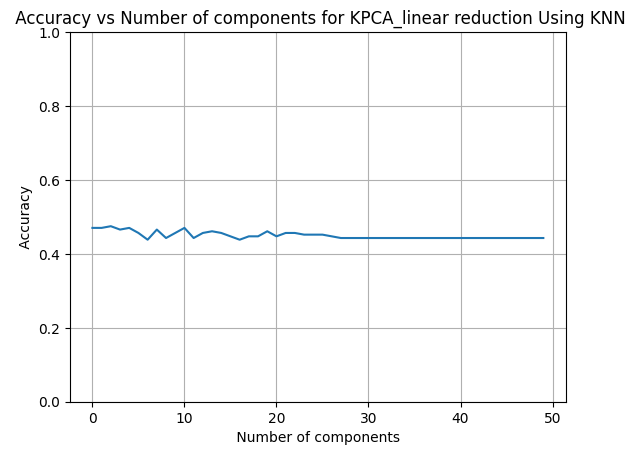

In [113]:
#Tests linear KPCA or 20 components with KNN classifier

best_n, highest_acc = test_and_plot('KPCA_linear', 'KNN', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [114]:
#evaluate linear KPCA with KNN clasififer
acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'KNN', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.4748858447488584
Precision: 0.38736681887366814
Recall: 0.4748858447488584


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.4611872146118721
Best number of components: 1
Highest accuracy: 0.4794520547945205
The number of components with highest accuracy is 1 with accuracy score 0.4794520547945205.


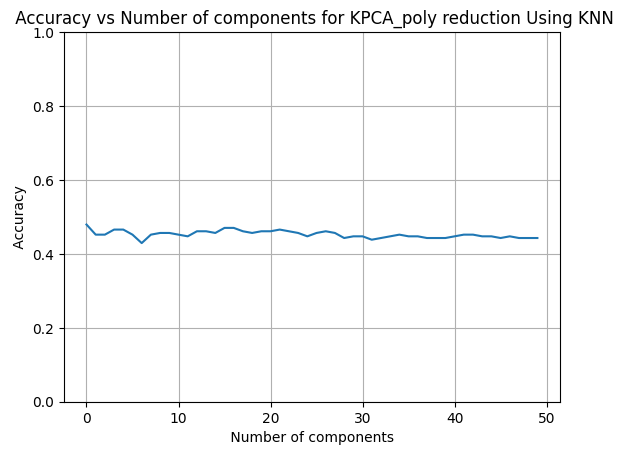

In [115]:
#Tests polynomial KPCA or 20 components with KNN classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'KNN', X_train, X_test, y_train, y_test, start_components=20, max_components=50)


In [116]:
#evaluate polynomial KPCA with KNN clasififer
acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'KNN', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.4794520547945205
Precision: 0.42142316740291724
Recall: 0.4794520547945205


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.3972602739726027


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.3972602739726027
The number of components with highest accuracy is 1 with accuracy score 0.3972602739726027.


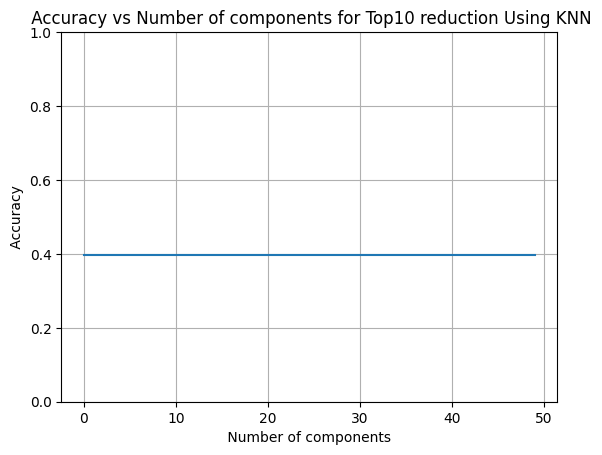

In [117]:
#Tests top 10 or 20 components with KNN classifier

best_n, highest_acc = test_and_plot('Top10', 'KNN', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [118]:
#evaluate top 10 with KNN clasififer
acc_score, prec_score, rec_score = eval_model('Top10', 'KNN', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.3972602739726027
Precision: 0.3617683686176837
Recall: 0.3972602739726027


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

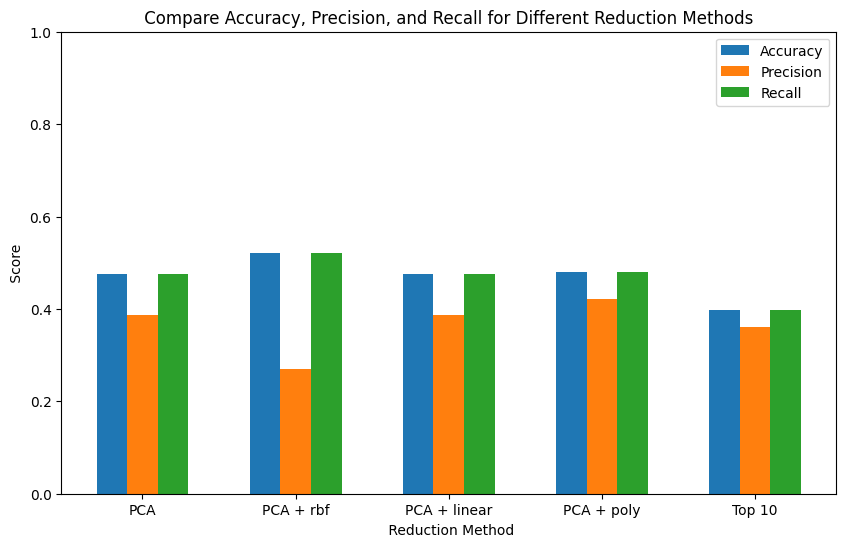

In [119]:
#compare the accuracy, precision, and recall for each reduction method using KNN Classifier

compare_methods(comparison_dict)

PCA, KPCA + linear, KPCA + poly gave very similar results. KPCA + rbf had higher accuracy and recall, but lower precision. Top 10 had lower accuracy and recall. It had a higher precision than KPCA + rbf, but lower than PCA, KPCA + linear, and KPCA + poly.

0.5205479452054794
Best number of components: 14
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 14 with accuracy score 0.5251141552511416.


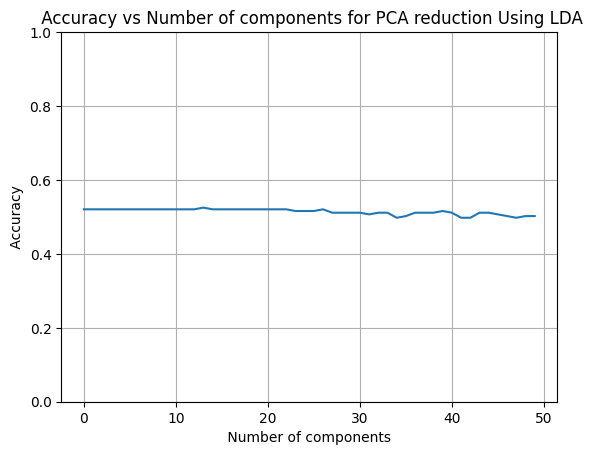

In [120]:

#test with PCA and LDA classifier

best_n, highest_acc = test_and_plot('PCA', 'LDA', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [121]:
#Evaluate classification performance for PCA with LDA using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'LDA', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Skipping iteration 9 due to ARPACK error -1: No convergence (8721 iterations, 8/9 eigenvectors converged)
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no id

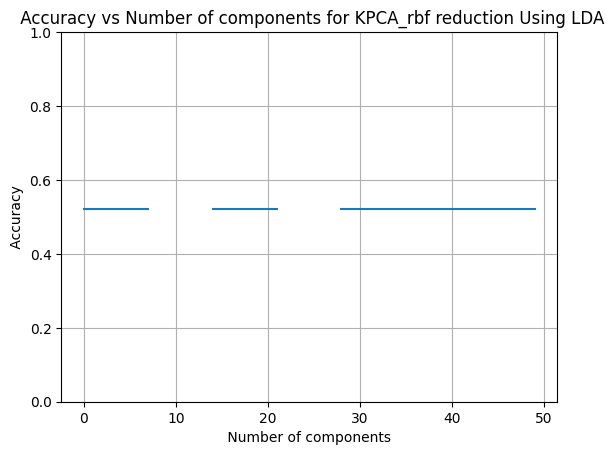

In [122]:
#Tests rbf KPCA for 20 components with LDA classifier

best_n, highest_acc = test_and_plot('KPCA_rbf', 'LDA', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [123]:
#evaluate classifications for rbf KPCA with LDA classifier

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'LDA', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Best number of components: 14
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 14 with accuracy score 0.5251141552511416.


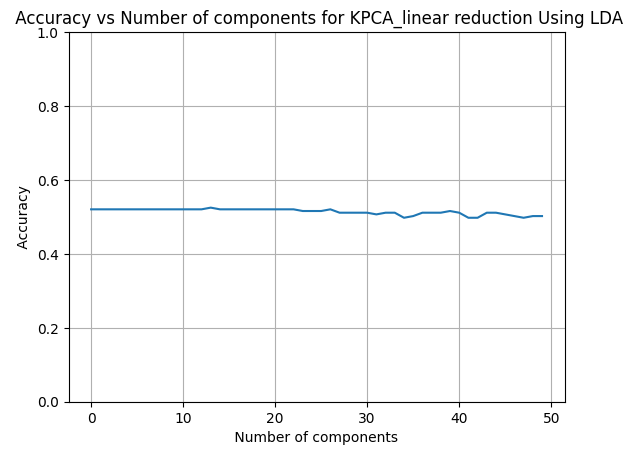

In [124]:
#Tests linear KPCA for 20 components with LDA classifier

best_n, highest_acc = test_and_plot('KPCA_linear', 'LDA', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [125]:
#evaluate classifications for linear KPCA with LDA classifier

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'LDA', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5068493150684932
Best number of components: 5
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 5 with accuracy score 0.5251141552511416.


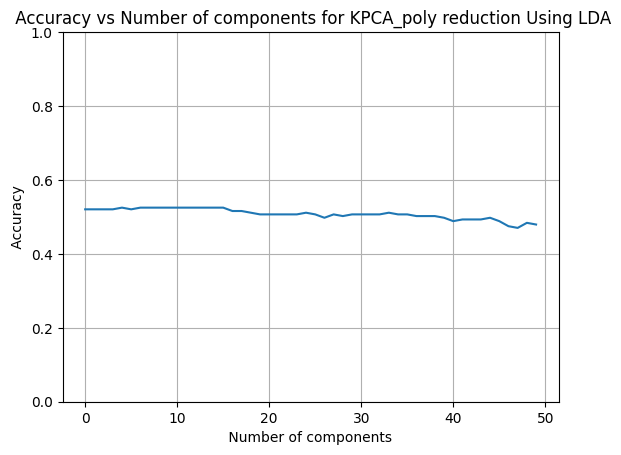

In [126]:
#Tests polynomial KPCA for 20 components with LDA classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'LDA', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [127]:
#evaluate classifications for polynomial KPCA with LDA classifier

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'LDA', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.5114155251141552


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.5114155251141552
The number of components with highest accuracy is 1 with accuracy score 0.5114155251141552.


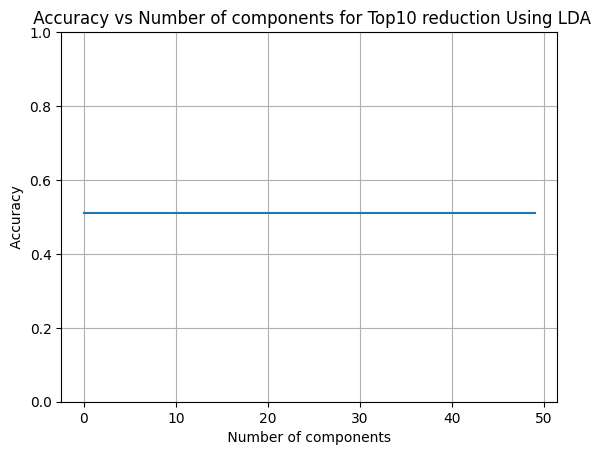

In [128]:
#Tests top10 for 20 components with LDA classifier

best_n, highest_acc = test_and_plot('Top10', 'LDA', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [129]:
#evaluate classifications for Top 10 with LDA classifier

acc_score, prec_score, rec_score = eval_model('Top10', 'LDA', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5114155251141552
Precision: 0.27840896794996645
Recall: 0.5114155251141552


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

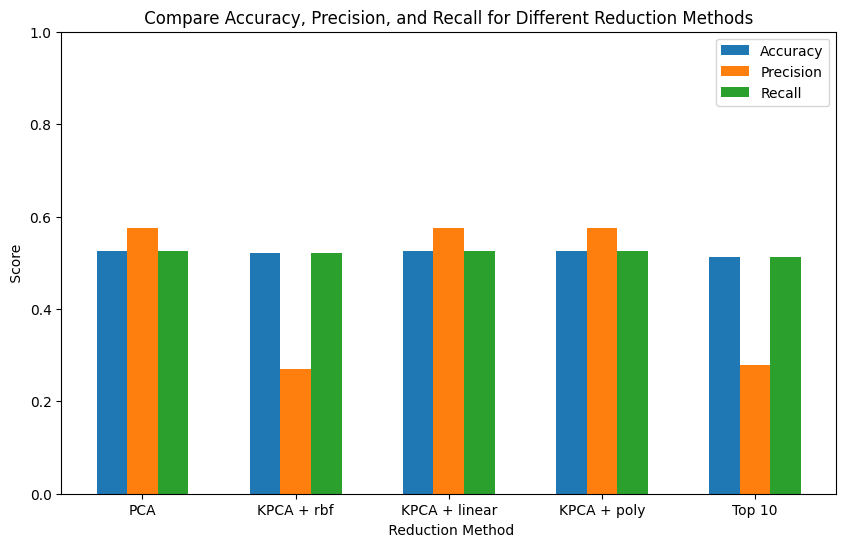

In [130]:
#compare the accuracy, precision, and recall for each reduction method using LDA Classifier

compare_methods(comparison_dict)

0.5205479452054794
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


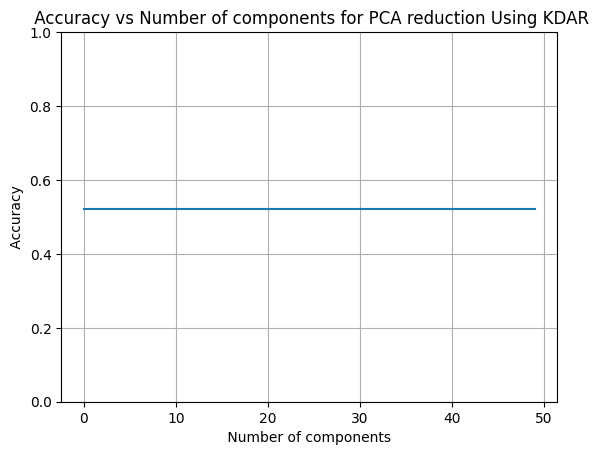

In [133]:
#test with PCA and KDA rbf classifier

best_n, highest_acc = test_and_plot('PCA', 'KDAR', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [134]:
#Evaluate classification performance for PCA with KDA rbf using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'KDAR', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
S

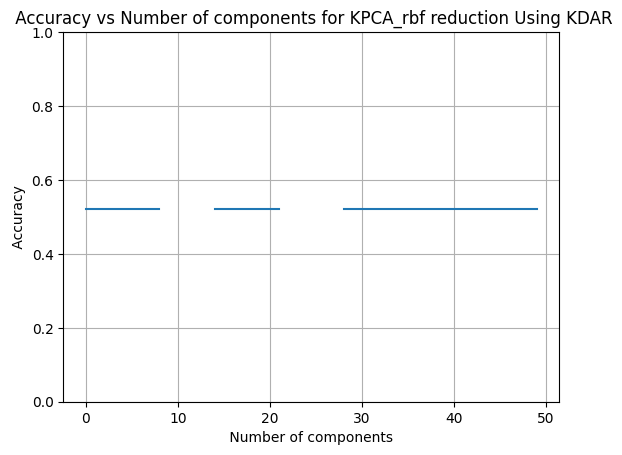

In [135]:
#Tests rbf KPCA for 20 components with KDA rbf classifier

best_n, highest_acc = test_and_plot('KPCA_rbf', 'KDAR', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [136]:
#evaluate classifications for rbf KPCA with KDA rbf classifier

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'KDAR', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


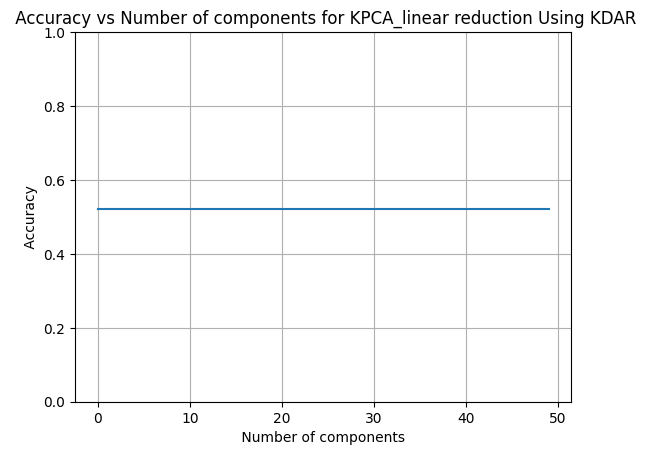

In [137]:
#Tests linear KPCA for 20 components with KDA rbf classifier

best_n, highest_acc = test_and_plot('KPCA_linear', 'KDAR', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [138]:
#evaluate classifications for linear KPCA with KDA rbf classifier

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'KDAR', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


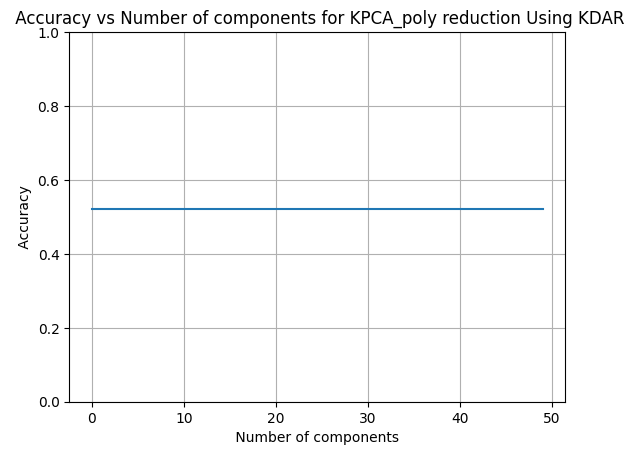

In [139]:
#Tests polynomial KPCA for 20 components with KDA rbf classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'KDAR', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [140]:
#evaluate classifications for polynomial KPCA with KDA rbf classifier

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'KDAR', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


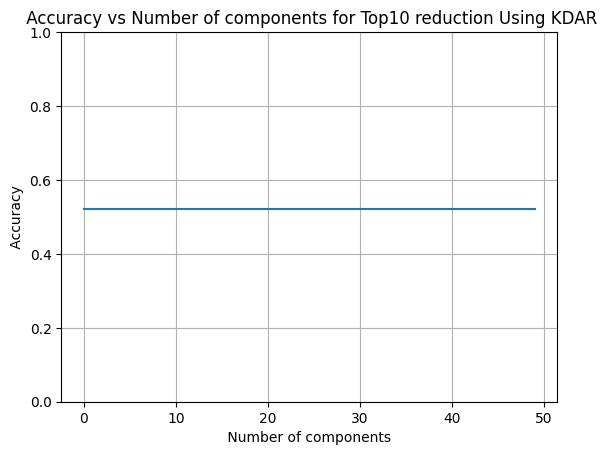

In [141]:
#Tests top10 for 20 components with KDA rbf classifier

best_n, highest_acc = test_and_plot('Top10', 'KDAR', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [142]:
#evaluate classifications for Top 10 with KDA rbf classifier

acc_score, prec_score, rec_score = eval_model('Top10', 'KDAR', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Accuracy: 0.5205479452054794
Precision: 0.27097016325764683
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


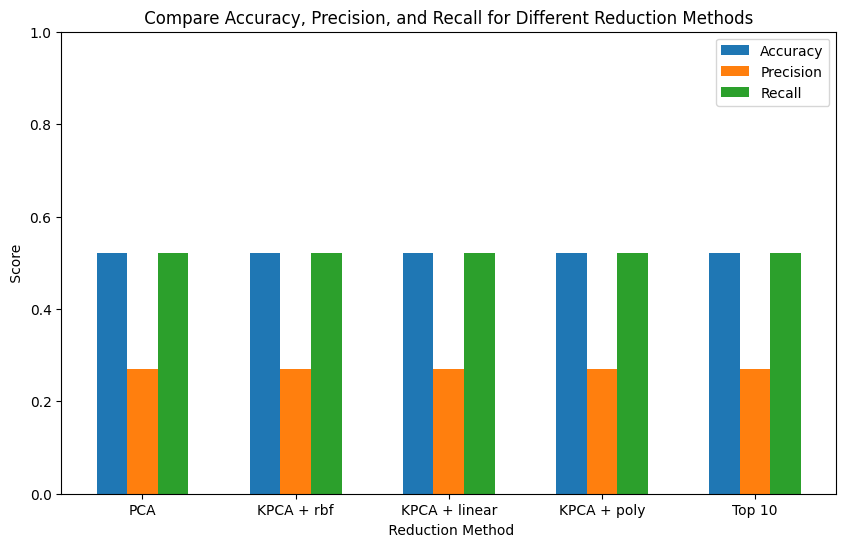

In [143]:
#compare the accuracy, precision, and recall for each reduction method using KDA RBF Classifier

compare_methods(comparison_dict)

When using KDA RBF Classifier, the different reduction methods returned results that were pretty much the same for all reduction methods. The accuracy, precision, and recall were all the same.

0.5251141552511416
Best number of components: 1
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 1 with accuracy score 0.5251141552511416.


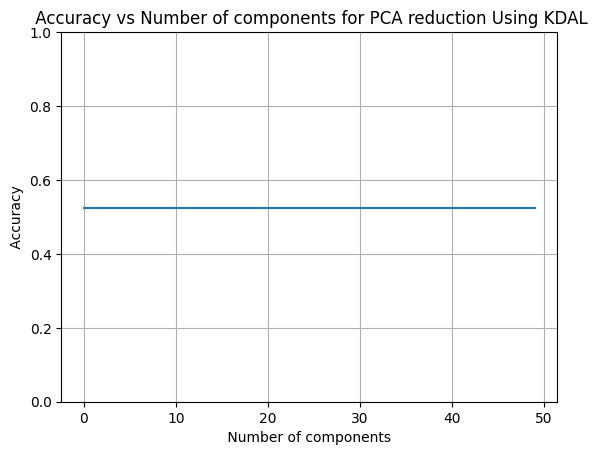

In [144]:
#test with PCA and KDA linear classifier

best_n, highest_acc = test_and_plot('PCA', 'KDAL', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [145]:
#Evaluate classification performance for PCA with KDA linear using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'KDAL', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5251141552511416
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 27 due to zero-size array to reduction operation maximum which has no identity
S

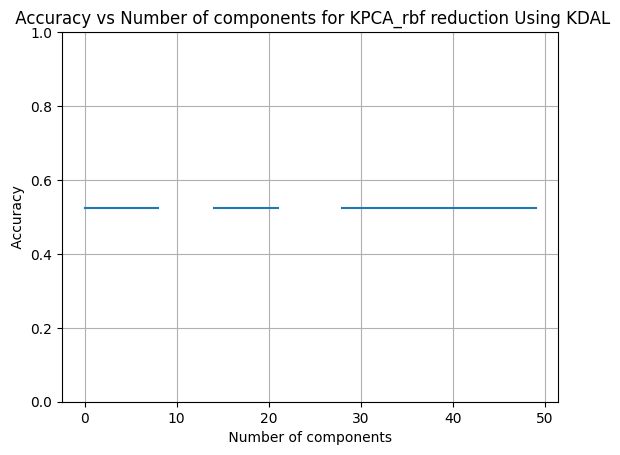

In [146]:
#Tests rbf KPCA for 20 components with KDA linear classifier

best_n, highest_acc = test_and_plot('KPCA_rbf', 'KDAL', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [147]:
#evaluate classifications for rbf KPCA with KDA linear classifier

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'KDAL', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5251141552511416
Best number of components: 1
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 1 with accuracy score 0.5251141552511416.


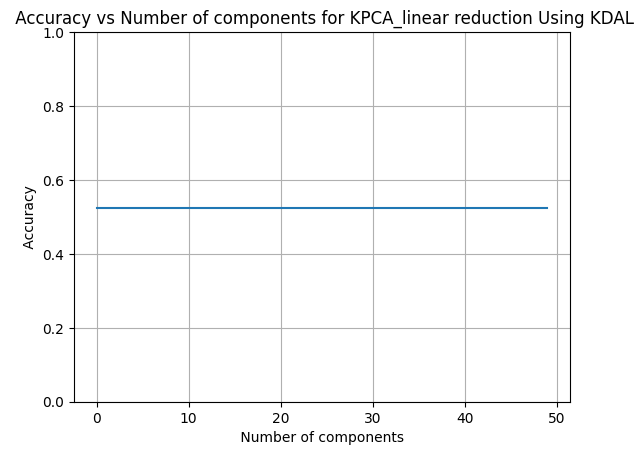

In [148]:
#Tests linear KPCA for 20 components with KDA linear classifier

best_n, highest_acc = test_and_plot('KPCA_linear', 'KDAL', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [149]:
#evaluate classifications for linear KPCA with KDA linear classifier

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'KDAL', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5251141552511416
Best number of components: 1
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 1 with accuracy score 0.5251141552511416.


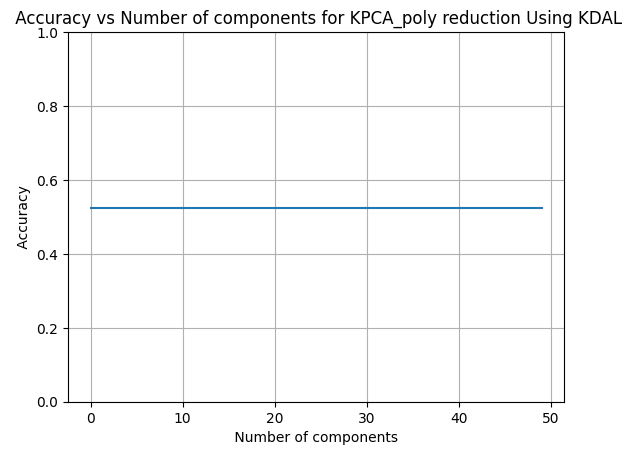

In [150]:
#Tests polynomial KPCA for 20 components with KDA linear classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'KDAL', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [151]:
#evaluate classifications for poly KPCA with KDA linear classifier

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'KDAL', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.5251141552511416
The number of components with highest accuracy is 1 with accuracy score 0.5251141552511416.


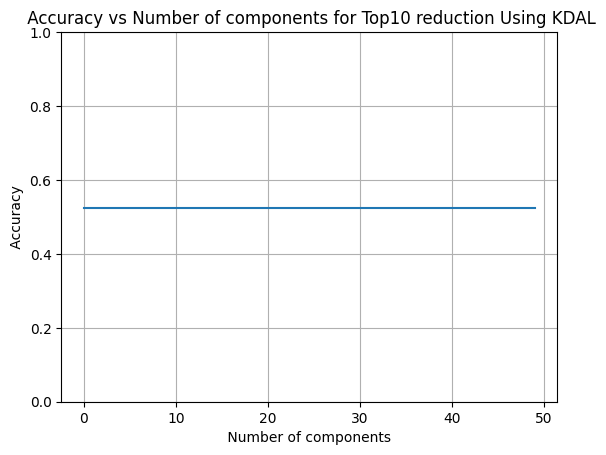

In [152]:
#Tests top10 for 20 components with KDA linear classifier

best_n, highest_acc = test_and_plot('Top10', 'KDAL', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [153]:
#evaluate classifications for Top 10 with KDA linear classifier

acc_score, prec_score, rec_score = eval_model('Top10', 'KDAL', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Accuracy: 0.5251141552511416
Precision: 0.5748374471308629
Recall: 0.5251141552511416


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


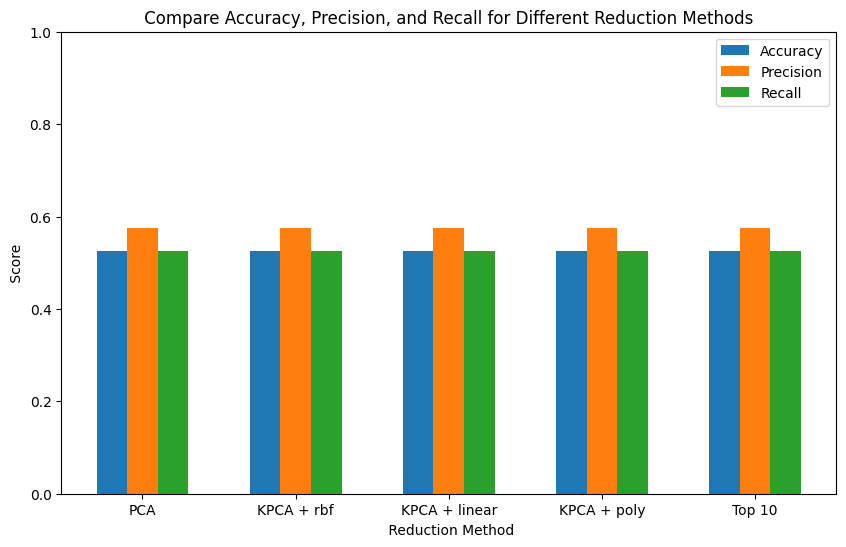

In [154]:
#compare the accuracy, precision, and recall for each reduction method using KDA linear classifier

compare_methods(comparison_dict)

The outputs were again about the same when using the KDA linear classifier.

0.5205479452054794
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


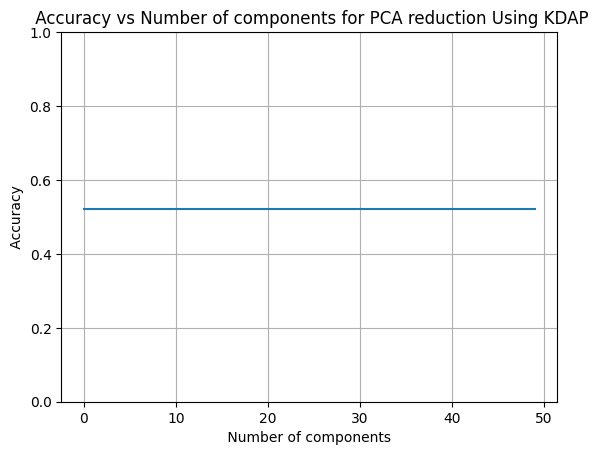

In [155]:
#test with PCA and KDA polynomial classifier

best_n, highest_acc = test_and_plot('PCA', 'KDAP', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [156]:
#Evaluate classification performance for PCA with KDA polynomial using ideal number of components

comparison_dict = {}

acc_score, prec_score, rec_score = eval_model('PCA', 'KDAP', best_n, X_train, X_test, y_train, y_test)

comparison_dict['PCA'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.42427524689391527
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Skipping iteration 8 due to ARPACK error -1: No convergence (8721 iterations, 7/8 eigenvectors converged)
Skipping iteration 10 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 11 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 12 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 13 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 14 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 23 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 24 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 25 due to zero-size array to reduction operation maximum which has no identity
Skipping iteration 26 due to zero-size array to reduction operation maximum which has no id

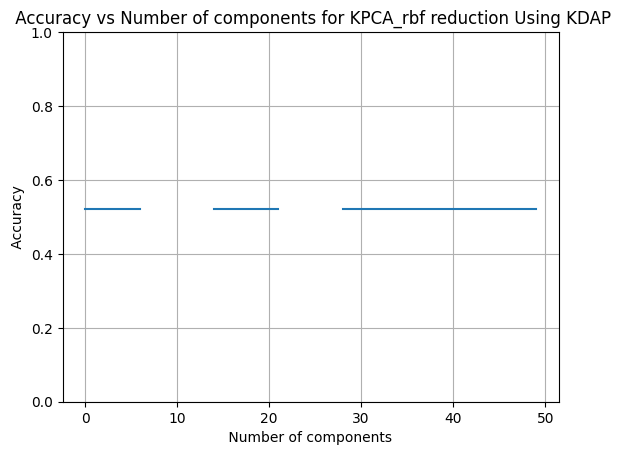

In [157]:
#Tests rbf KPCA for 20 components with KDA polynomial classifier

best_n, highest_acc = test_and_plot('KPCA_rbf', 'KDAP', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [158]:
#evaluate classifications for rbf KPCA with KDA polynomial classifier

acc_score, prec_score, rec_score = eval_model('KPCA_rbf', 'KDAP', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + rbf'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.42427524689391527
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


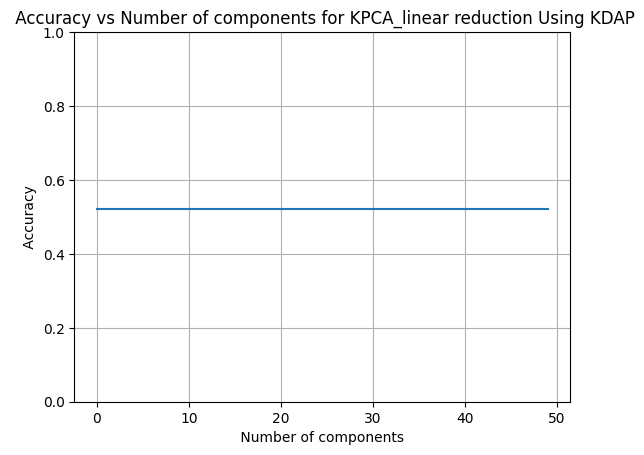

In [159]:
#Tests linear KPCA for 20 components with KDA polynomial classifier

best_n, highest_acc = test_and_plot('KPCA_linear', 'KDAP', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [160]:
#evaluate classifications for linear KPCA with KDA polynomial classifier

acc_score, prec_score, rec_score = eval_model('KPCA_linear', 'KDAP', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + linear'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.42427524689391527
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5205479452054794
Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


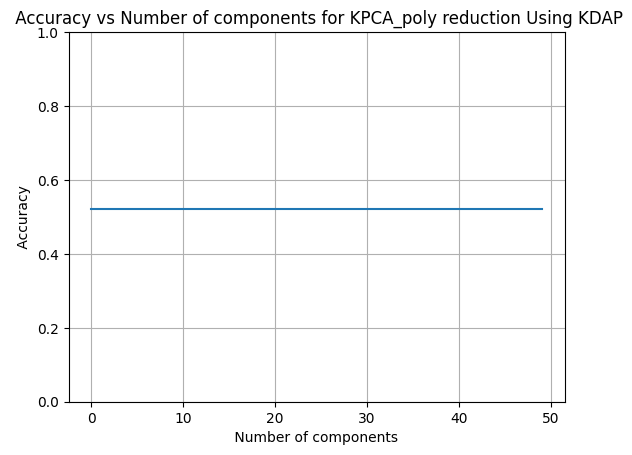

In [161]:
#Tests polynomial KPCA for 20 components with KDA polynomial classifier

best_n, highest_acc = test_and_plot('KPCA_poly', 'KDAP', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [162]:
#evaluate classifications for poly KPCA with KDA polynomial classifier

acc_score, prec_score, rec_score = eval_model('KPCA_poly', 'KDAP', best_n, X_train, X_test, y_train, y_test)

comparison_dict['KPCA + poly'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

Accuracy: 0.5205479452054794
Precision: 0.42427524689391527
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Best number of components: 1
Highest accuracy: 0.5205479452054794
The number of components with highest accuracy is 1 with accuracy score 0.5205479452054794.


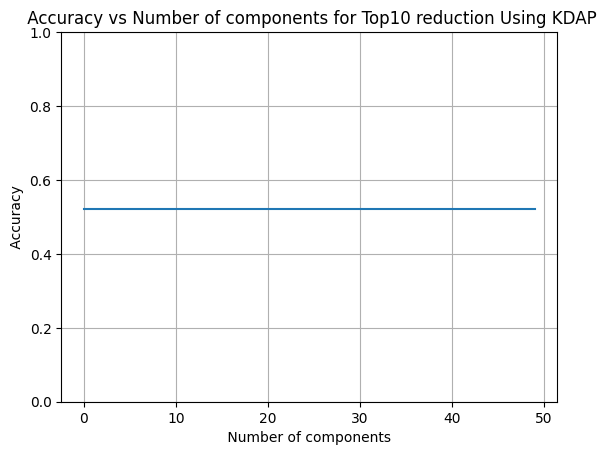

In [163]:
#Tests top10 for 20 components with KDA polynomial classifier

best_n, highest_acc = test_and_plot('Top10', 'KDAP', X_train, X_test, y_train, y_test, start_components=20, max_components=50)

In [164]:
#evaluate classifications for Top 10 with KDA polynomial classifier

acc_score, prec_score, rec_score = eval_model('Top10', 'KDAP', best_n, X_train, X_test, y_train, y_test)

comparison_dict['Top 10'] = {'Number of Components': best_n, 'Accuracy': acc_score, 'Precision': prec_score, 'Recall': rec_score}

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  18   19   32   41   42   45   46   48   57   58   69   70   84   85
   95  102  112  113  114  115  121  150  151  152  153  155  156  157
  158  159  160  169  172  196  258  259  260  277  278  279  333  340
  347  348  363  364  365  366  372  384  435  436  437  438  467  481
  525  526  546  550  551  552  553  554  569  570  576  577  582  586
  587  619  660  662  663  664  674  675  676  678  682  684  685  688
  689  690  691  692  693  695  696  697  698  700  704  705  706  707
  709  711  715  716  718  719  722  723  724  726  727  728  729  730
  732  734  737  739  740  743  745  746  753  756  757  759  762  796
  804  805  808  821  822  825  827  828  833  838  847  851  855  864
  865  866  874  889  896  907 1086 1145 1186 1222 1227 1228 1233 1234
 1259 1260 1263 1264 1265 1267 1269 1270 1271 1272 1290 1300 1304 1324
 1327 1329 1338 1340 1345 1357

Accuracy: 0.5205479452054794
Precision: 0.42427524689391527
Recall: 0.5205479452054794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


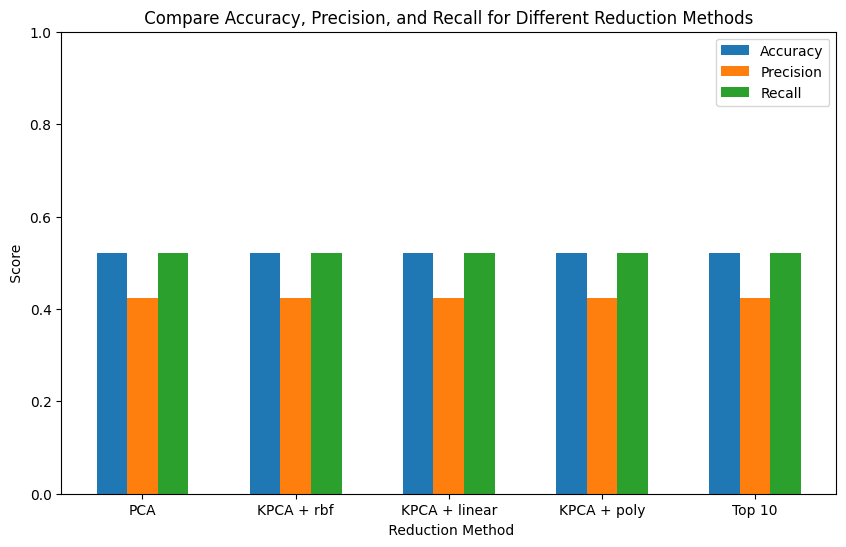

In [165]:
#compare the accuracy, precision, and recall for each reduction method using KDA linear classifier

compare_methods(comparison_dict)

When using the KDA linear classifier, the outputs were the same for all the reduction methods.